# Filament Diameter Data Analysis

In [179]:
import os
import pandas as pd
import re
import numpy as np
import statsmodels.stats.multicomp as multi
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import MultiComparison, pairwise_tukeyhsd
from scikit_posthocs import posthoc_dunn
from statsmodels.graphics.factorplots import interaction_plot
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import warnings
import gc
import itertools
import glob
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [180]:
gc.collect()

107504

In [87]:
# Global switch to control the use of rolling averages and segmenting
rolling_average_switch = True
segment_switch = False
rolling_avg_resolution = 1
down_sample_value = 1

In [88]:
# Define both directories and individual files
directories = {
    'PETG_01': r'C:\Users\David\Documents\Eric_Work\PETG\PETG_01_BS',
    'PETG_05': r'C:\Users\David\Documents\Eric_Work\PETG\PETG_05_BS',
    'PLA_04': r'C:\Users\David\Documents\Eric_Work\PLA\PLA_04_BS'
}

file_paths = {
    'PLA_02': r'C:\Users\David\Documents\Eric_Work\PLA\PLA_02_BS.csv',
    'PLA_03': r'C:\Users\David\Documents\Eric_Work\PLA\PLA_03_BS.csv',
    'PLA_01': r'C:\Users\David\Documents\Eric_Work\PLA\PLA_01_BS.csv',
    'PETG_03': r'C:\Users\David\Documents\Eric_Work\PETG\PETG_03_BS.csv',
    'PETG_04': r'C:\Users\David\Documents\Eric_Work\PETG\PETG_04_BS.csv',
    'PETG_02': r'C:\Users\David\Documents\Eric_Work\PETG\PETG_02_BS.csv'
}

def process_data(path, start_index=0):
    df = pd.read_csv(path, skiprows=1, low_memory=False)
    numeric_columns = ['adc_1', 'adc_2', 'diameter_1', 'diameter_2', 'length']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df['counter'] = pd.to_numeric(df['counter'], errors='coerce')
    df.dropna(subset=numeric_columns + ['counter'], inplace=True)
    df['counter'] = (df['counter'] - df['counter'].iloc[0] + start_index).astype(int)
    df = df[(df['counter'] >= start_index) & (df['counter'] <= 300000)]
    if 'length' in df.columns and len(df['length']) > 1:
        initial_length = 1.494118
        increment = df['length'].iloc[1] - df['length'].iloc[0]
        df['length'] = initial_length + df['counter'] * increment
    return df

def process_directory(directory_path):
    csv_files = glob.glob(os.path.join(directory_path, '*.csv'))
    csv_files.sort()
    all_dataframes = []
    start_index = 0
    for file in csv_files:
        df = process_data(file, start_index=start_index)
        if not df.empty:
            start_index = df['counter'].max() + 1
        all_dataframes.append(df)
    return pd.concat(all_dataframes, ignore_index=True)

# Function to remove outliers from 'length' column
def remove_length_outliers(df):
    Q1 = df['length'].quantile(0.25)
    Q3 = df['length'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df['length'] >= lower_bound) & (df['length'] <= upper_bound)]

output_directory = r'C:\Users\David\Documents\Eric_Work\Processed_CSV_Files'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Process and store dataframes from both directories and individual files
dataframes = {}
for key, directory in directories.items():
    concatenated_df = process_directory(directory)
    output_path = os.path.join(output_directory, f'{key}_processed_data.csv')
    concatenated_df.to_csv(output_path, index=False)
    print(f'Saved {key} processed data to {output_path}')
    dataframes[key] = concatenated_df  # Add directory dataframes to the dictionary

for name, path in file_paths.items():
    dataframes[name] = process_data(path)  # Add individual file dataframes to the dictionary

# Optional: Segment Switch and Outlier Removal
if 'segment_switch' in globals() and segment_switch:
    segmented_dataframes = {}
    for name, df in dataframes.items():
        sixth = len(df) // 6
        segmented_dataframes[name] = {
            'first': remove_length_outliers(df.iloc[:sixth]),
            'second': remove_length_outliers(df.iloc[sixth:2*sixth]),
            'third': remove_length_outliers(df.iloc[2*sixth:3*sixth]),
            'fourth': remove_length_outliers(df.iloc[3*sixth:4*sixth]),
            'fifth': remove_length_outliers(df.iloc[4*sixth:5*sixth]),
            'sixth': remove_length_outliers(df.iloc[5*sixth:])
        }
    dataframes = segmented_dataframes

# Print the final DataFrames to verify
for name, df in dataframes.items():
    print(f"\n{name} DataFrame:")
    if 'segment_switch' in globals() and segment_switch:
        for segment, segment_df in df.items():
            print(f"{segment} Segment:")
            print(segment_df.tail())
    else:
        print(df.tail())
    print("-" * 40)


Saved PETG_01 processed data to C:\Users\David\Documents\Eric_Work\Processed_CSV_Files\PETG_01_processed_data.csv
Saved PETG_05 processed data to C:\Users\David\Documents\Eric_Work\Processed_CSV_Files\PETG_05_processed_data.csv
Saved PLA_04 processed data to C:\Users\David\Documents\Eric_Work\Processed_CSV_Files\PLA_04_processed_data.csv

PETG_01 DataFrame:
        counter  adc_1  adc_2  diameter_1  diameter_2         length
189363   189675   2592   2637    1.741213    1.782081  283398.258822
189364   189676   2590   2641    1.743731    1.777855  283399.752940
189365   189677   2586   2638    1.748768    1.781025  283401.247058
189366   189678   2590   2636    1.743731    1.783138  283402.741175
189367   189679   2594   2637    1.738694    1.782081  283404.235293
----------------------------------------

PETG_05 DataFrame:
        counter   adc_1   adc_2  diameter_1  diameter_2         length
213512   213511  3649.0  3895.0    0.410208    0.452820  319012.047057
213513   213512  3648.0

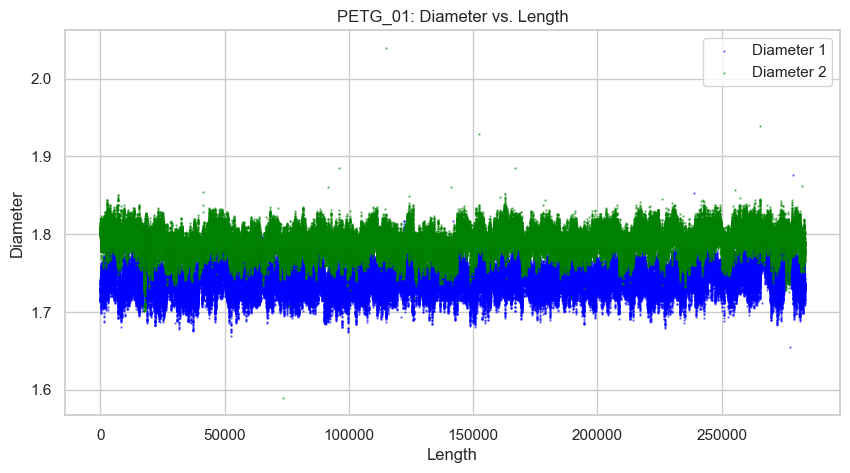

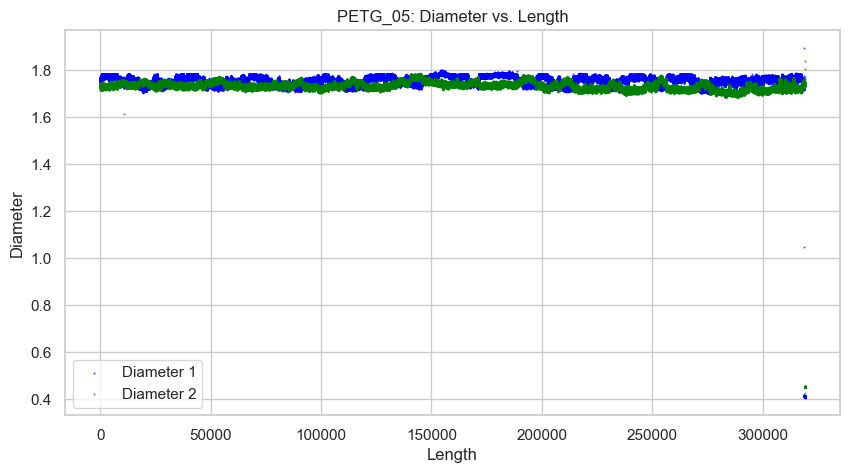

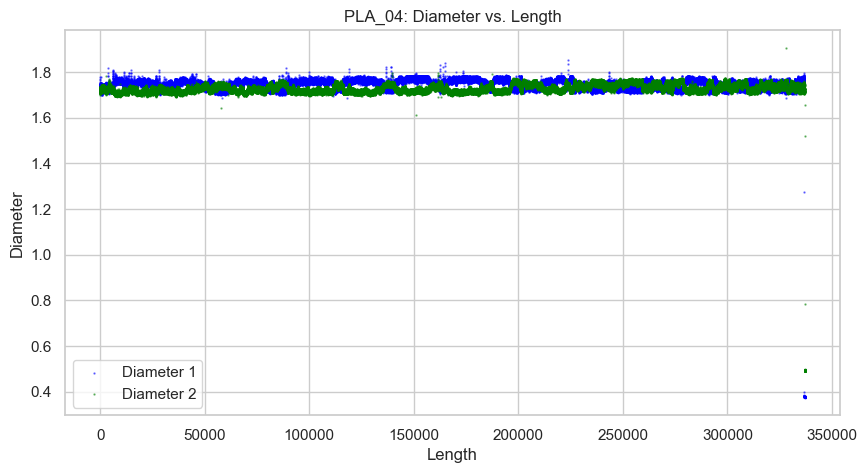

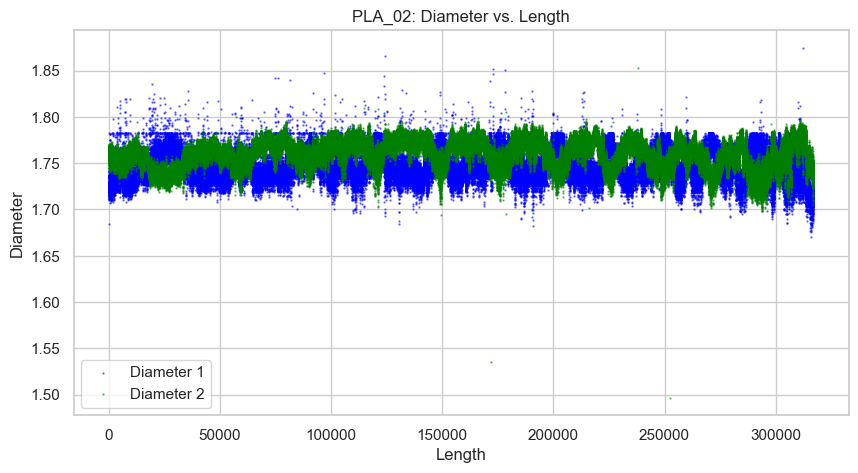

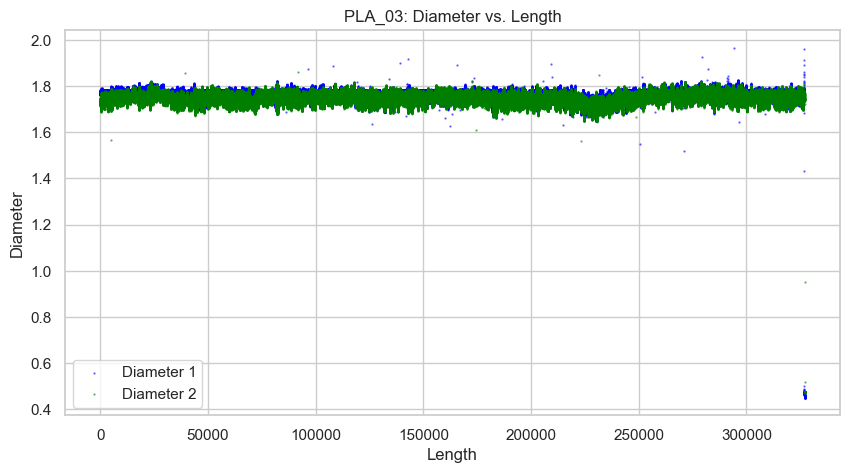

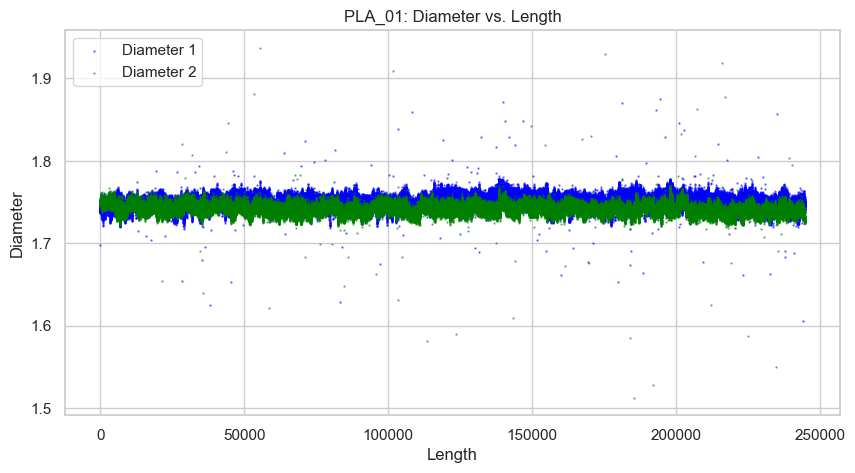

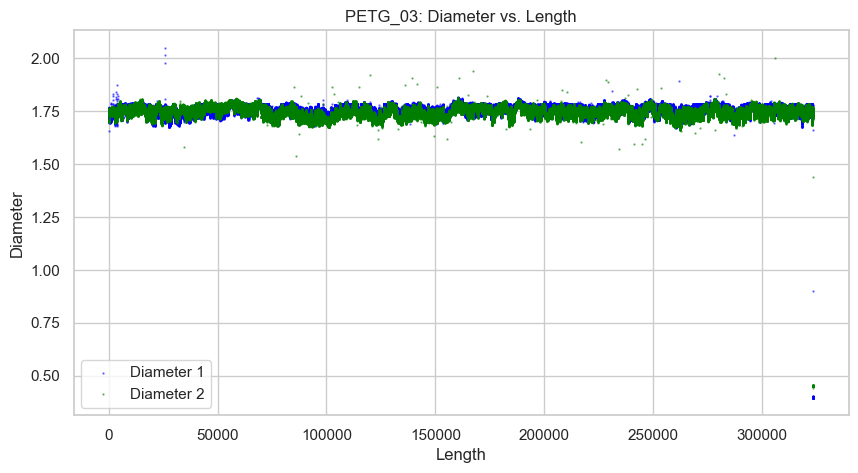

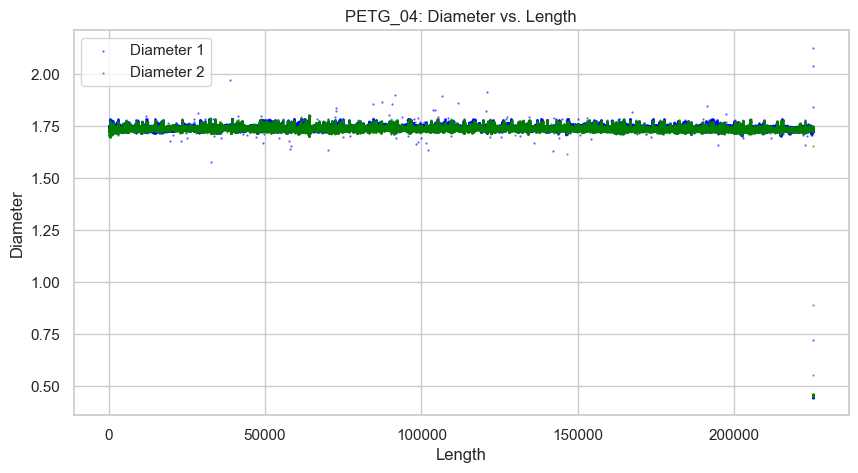

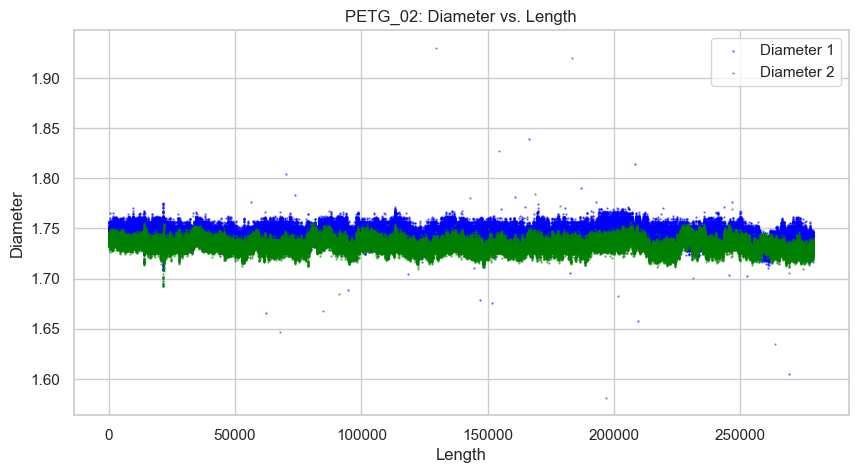

In [89]:
def plot_diameters(df, title):
    plt.figure(figsize=(10, 5))
    plt.scatter(df['length'], df['diameter_1'], alpha=0.5, label='Diameter 1', color='blue', s=0.5)
    plt.scatter(df['length'], df['diameter_2'], alpha=0.5, label='Diameter 2', color='green', s=0.5)

    plt.title(title)
    plt.xlabel('Length')
    plt.ylabel('Diameter')
    plt.legend()
    plt.grid(True)
    plt.show()

if segment_switch:
    for name, segments in dataframes.items():
        for segment_name, segment_df in segments.items():
            plot_diameters(segment_df, f'{name} - {segment_name}: Diameter vs. Length')
else:
    for name, df in dataframes.items():
        plot_diameters(df, f'{name}: Diameter vs. Length')


In [90]:
def remove_outliers(df, column_name):
    if column_name in df.columns:
        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df

def apply_rolling_average_and_downsample(df, downsample_factor, rolling_avg_resolution):
    # Create a copy to avoid modifying the original dataframe unintentionally
    df_copy = df.copy()

    # Apply rolling average conditionally on column existence
    if 'length' in df_copy.columns:
        df_copy['length_ra'] = df_copy['length'].rolling(window=rolling_avg_resolution, min_periods=1).mean()
    
    if 'diameter_1' in df_copy.columns:
        df_copy['diameter_1_ra'] = df_copy['diameter_1'].rolling(window=rolling_avg_resolution, min_periods=1).mean()
    
    if 'diameter_2' in df_copy.columns:
        df_copy['diameter_2_ra'] = df_copy['diameter_2'].rolling(window=rolling_avg_resolution, min_periods=1).mean()
    
    if 'diameter_1_ra' in df_copy.columns and 'diameter_2_ra' in df_copy.columns:
        df_copy['diameter_avg_ra'] = df_copy[['diameter_1_ra', 'diameter_2_ra']].mean(axis=1)
    elif 'diameter_avg' in df_copy.columns:
        df_copy['diameter_avg_ra'] = df_copy['diameter_avg'].rolling(window=rolling_avg_resolution, min_periods=1).mean()

    # Downsample by selecting every 'downsample_factor' row
    downsampled_df = df_copy.iloc[::downsample_factor].copy()  # Ensure to copy the downsized data to reset the index and avoid future warnings
    return downsampled_df


Starting preprocessing and analysis for PETG_01:
Preprocessing and analyzing for the whole dataset


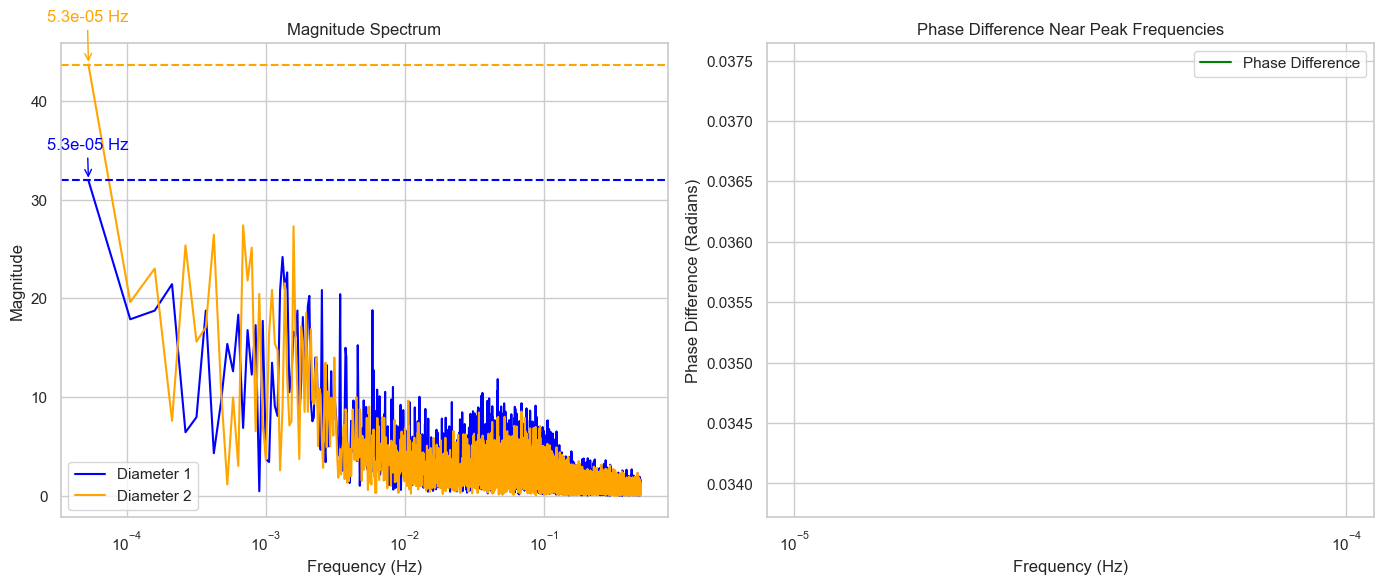

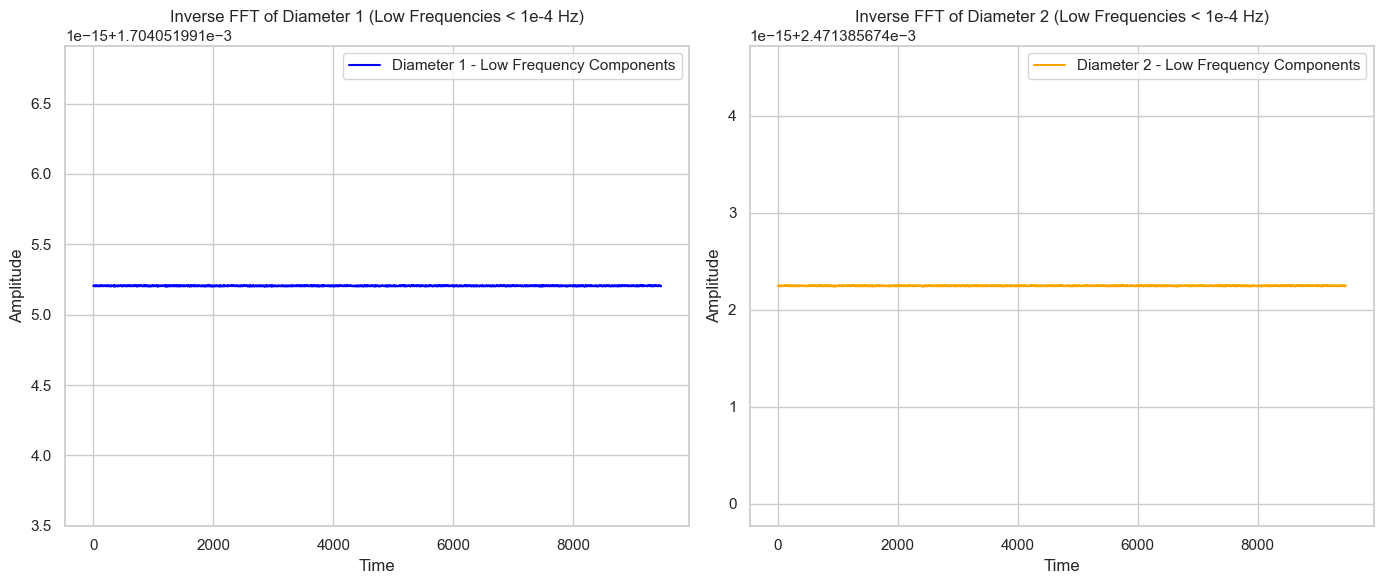

Starting preprocessing and analysis for PETG_05:
Preprocessing and analyzing for the whole dataset


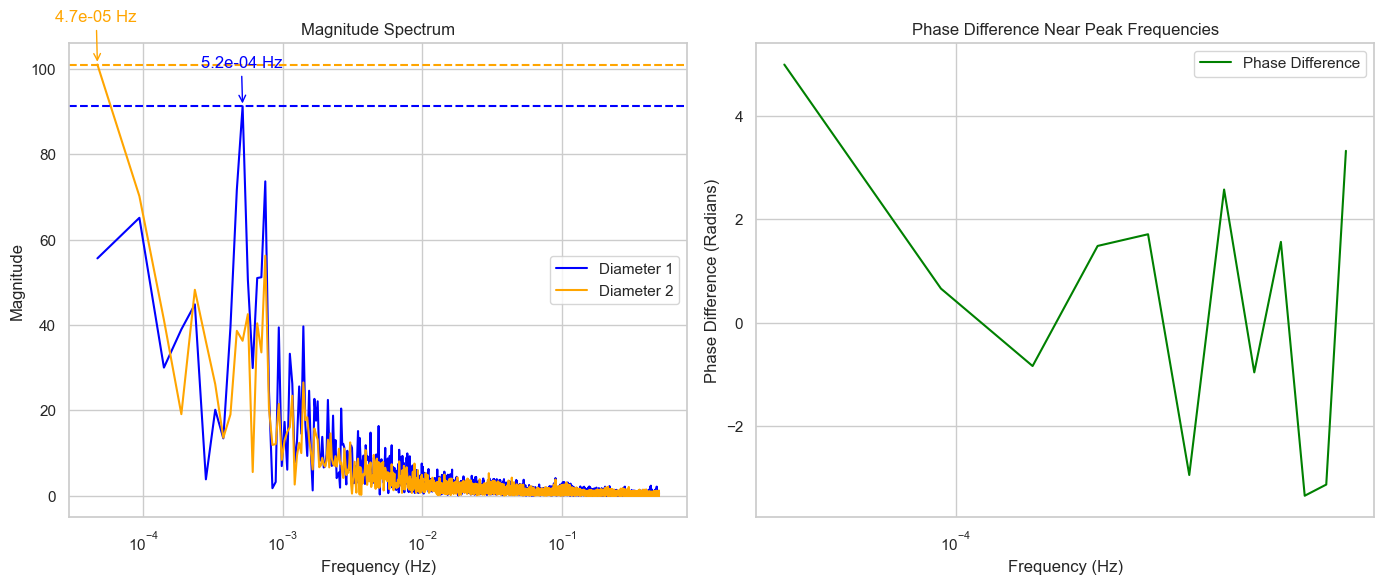

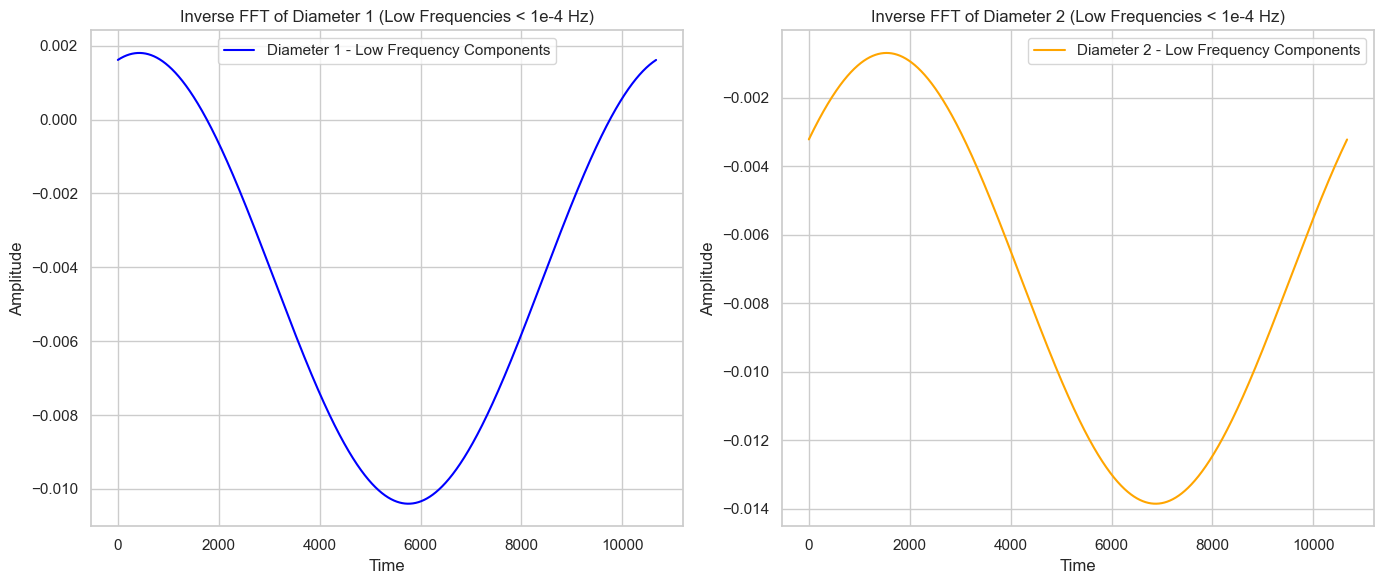

Starting preprocessing and analysis for PLA_04:
Preprocessing and analyzing for the whole dataset


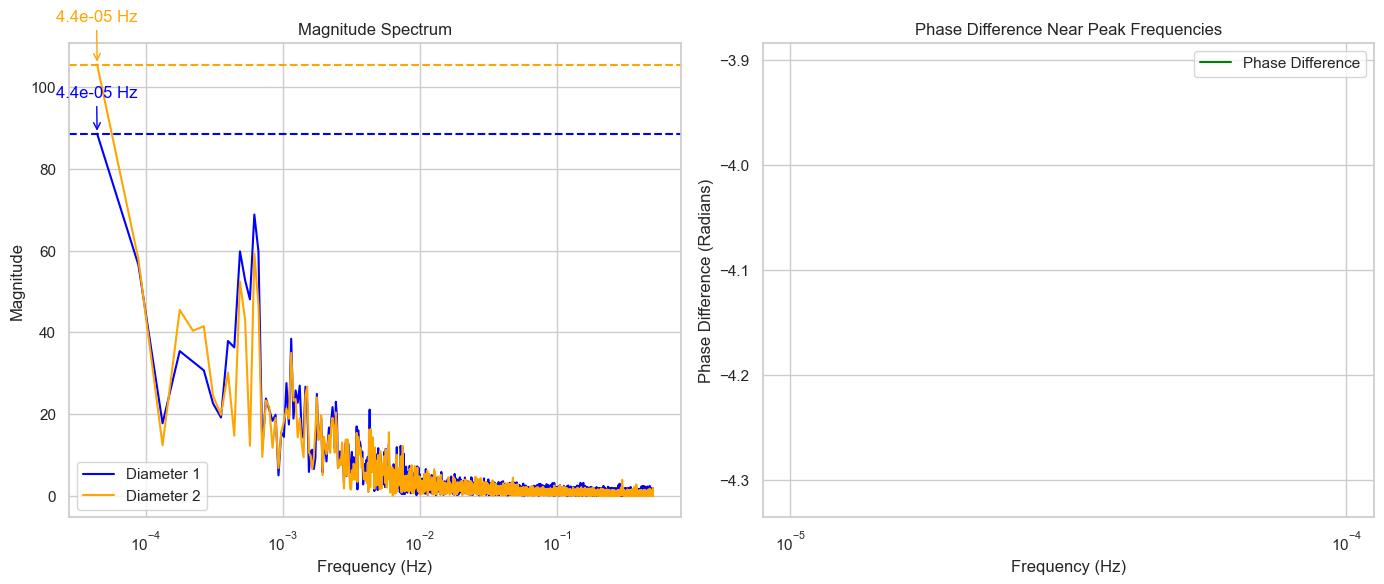

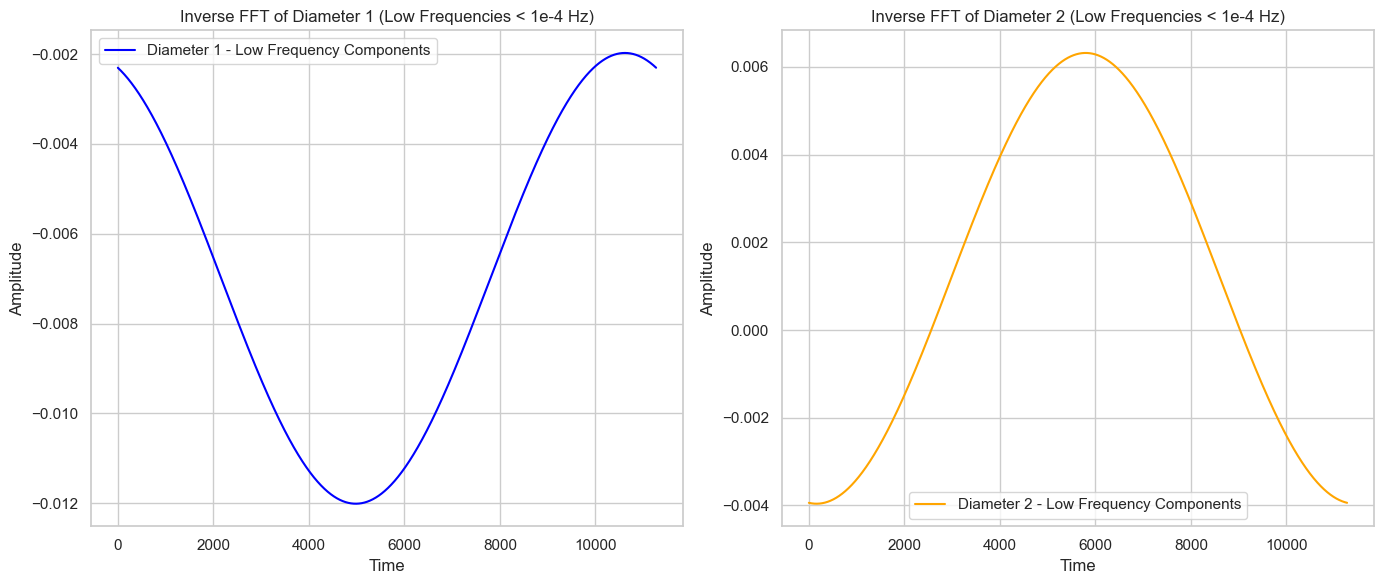

Starting preprocessing and analysis for PLA_02:
Preprocessing and analyzing for the whole dataset


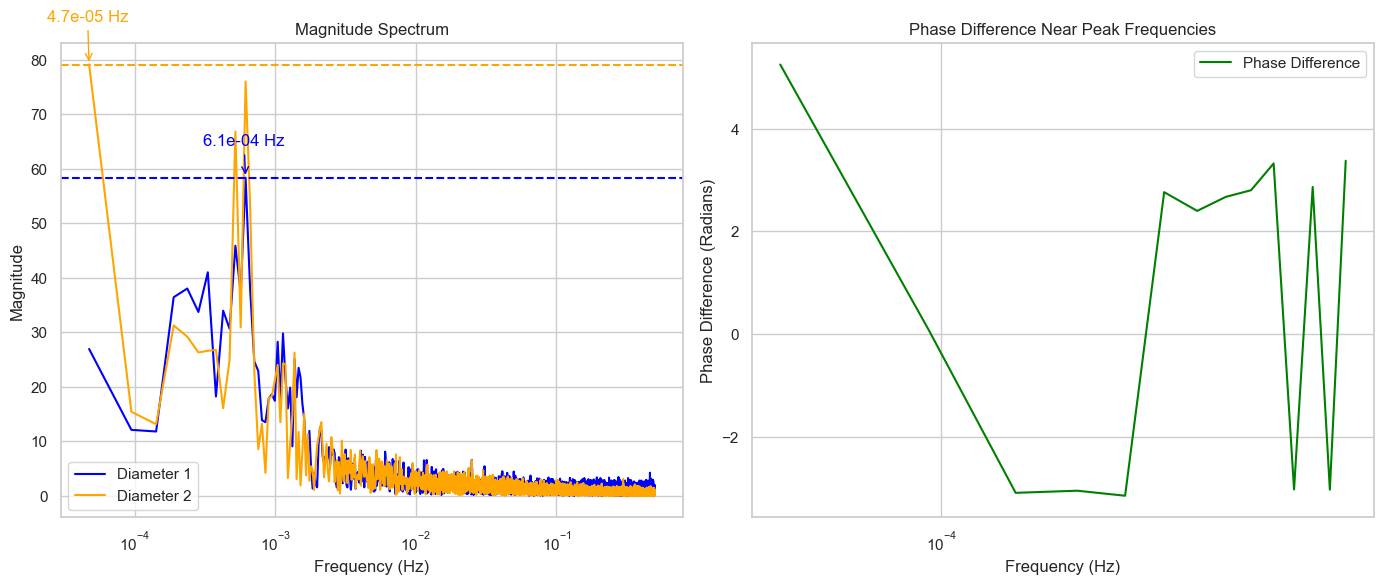

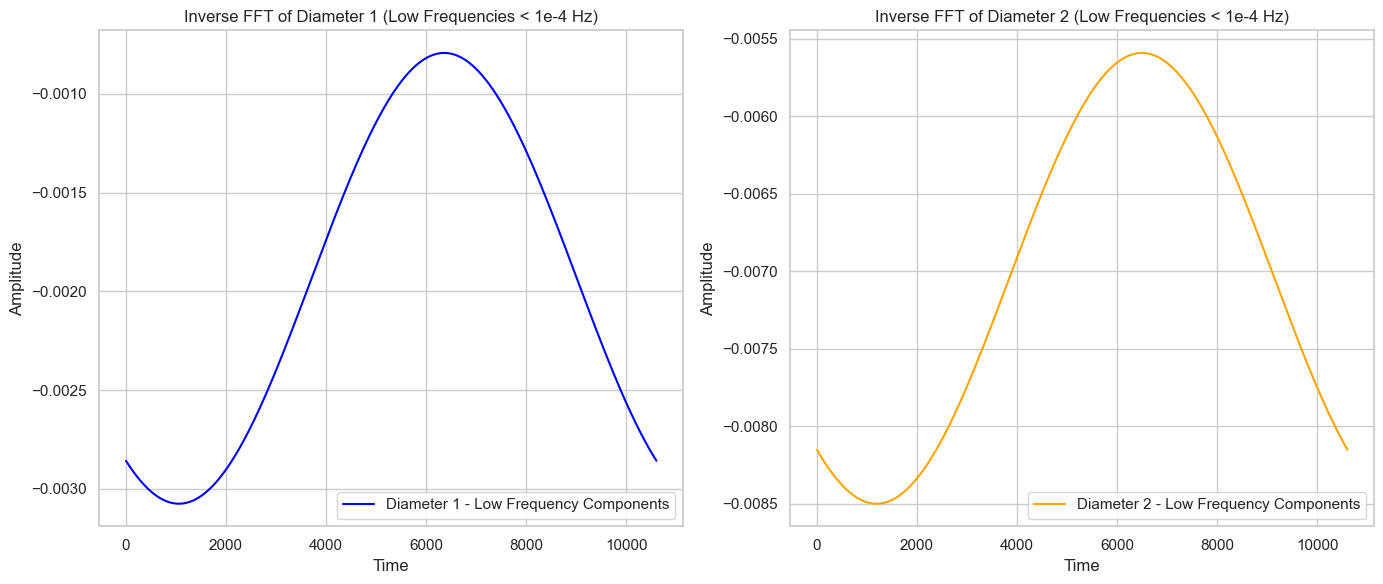

Starting preprocessing and analysis for PLA_03:
Preprocessing and analyzing for the whole dataset


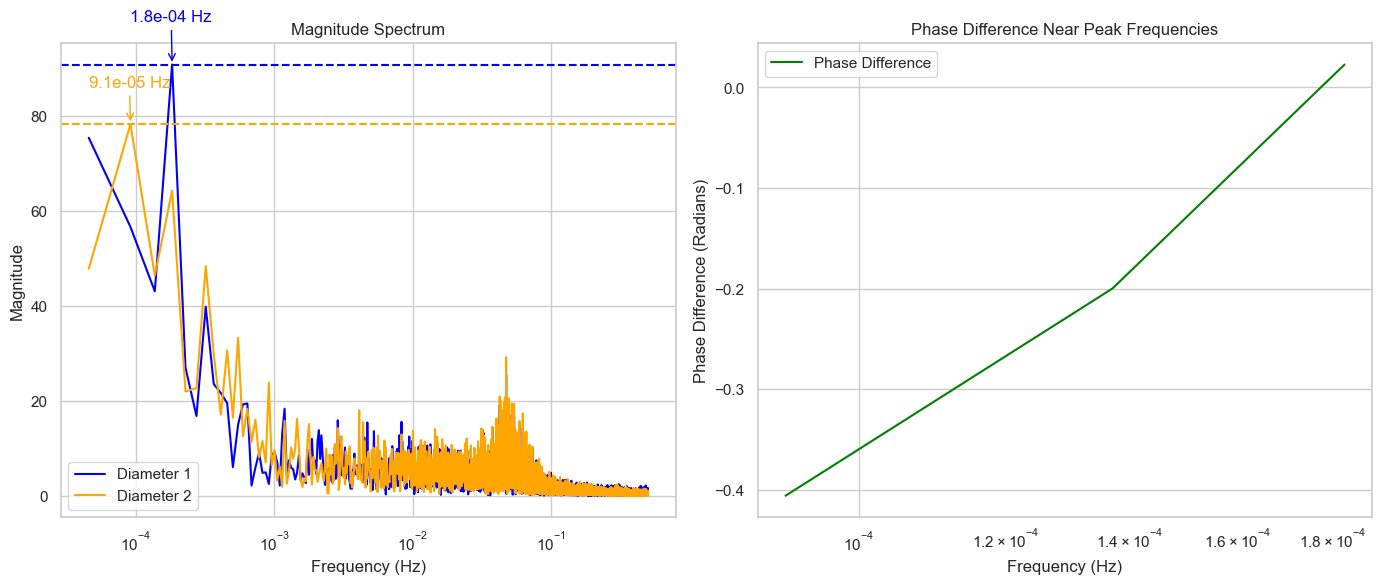

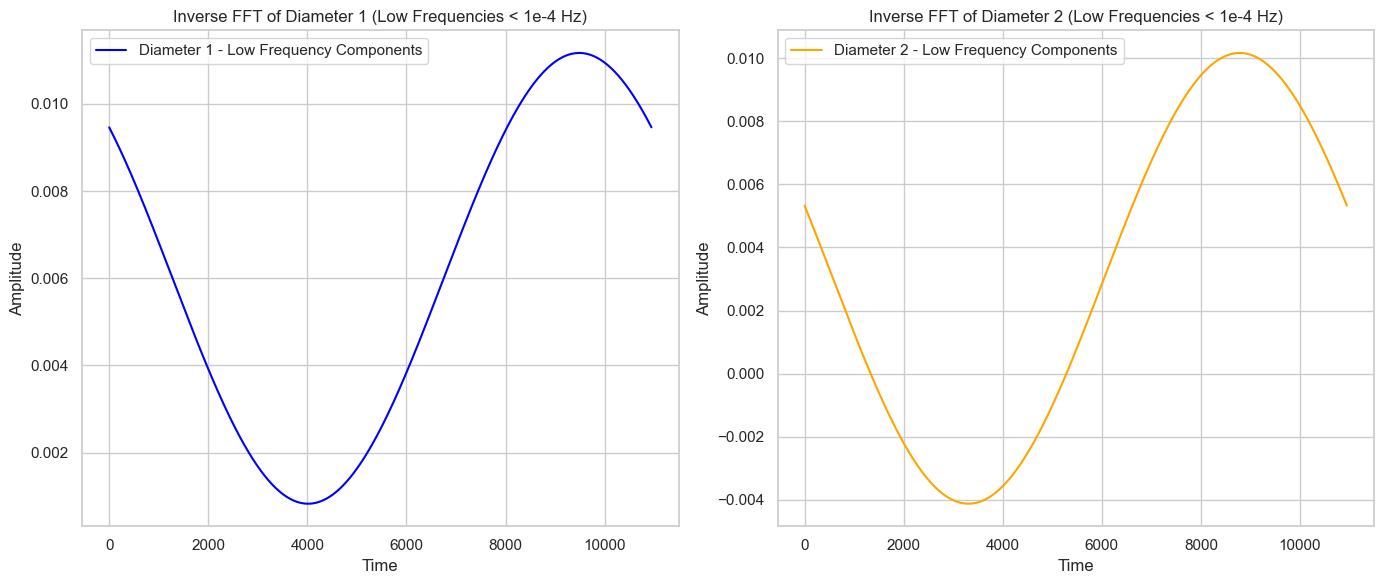

Starting preprocessing and analysis for PLA_01:
Preprocessing and analyzing for the whole dataset


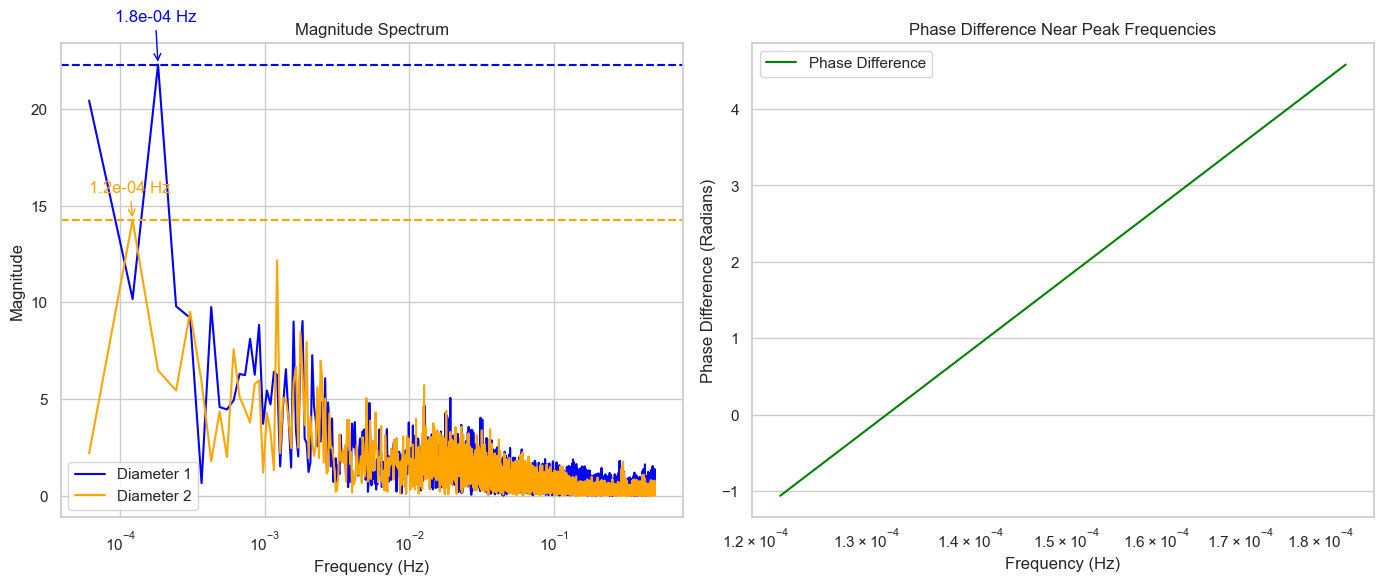

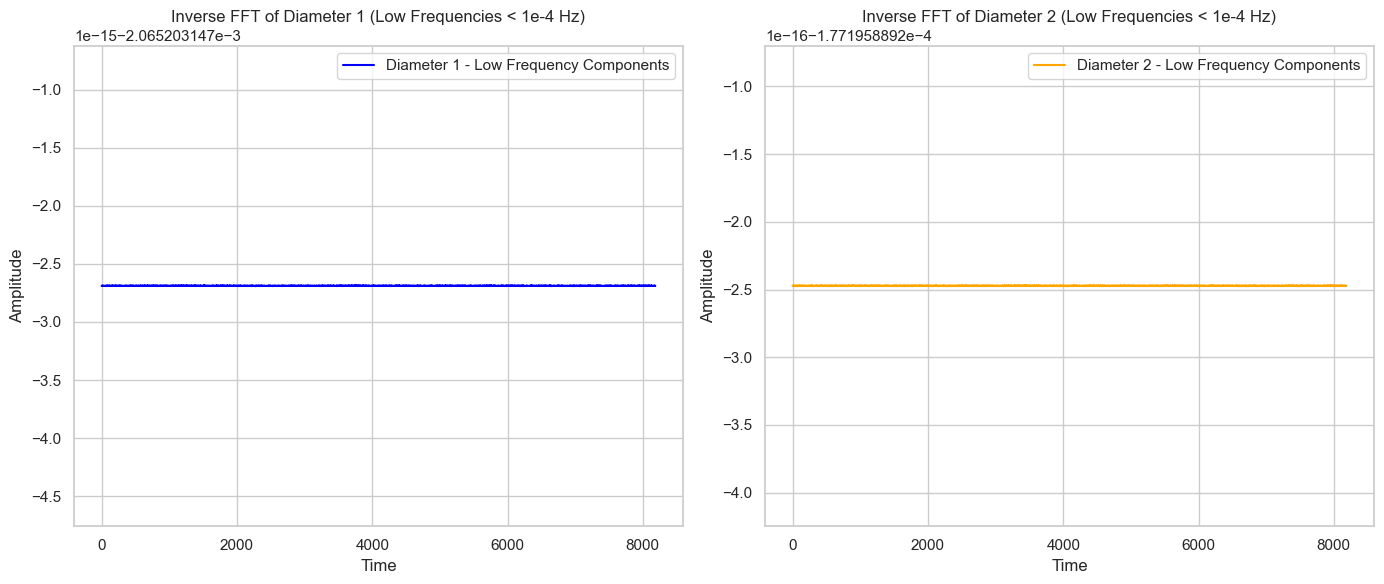

Starting preprocessing and analysis for PETG_03:
Preprocessing and analyzing for the whole dataset


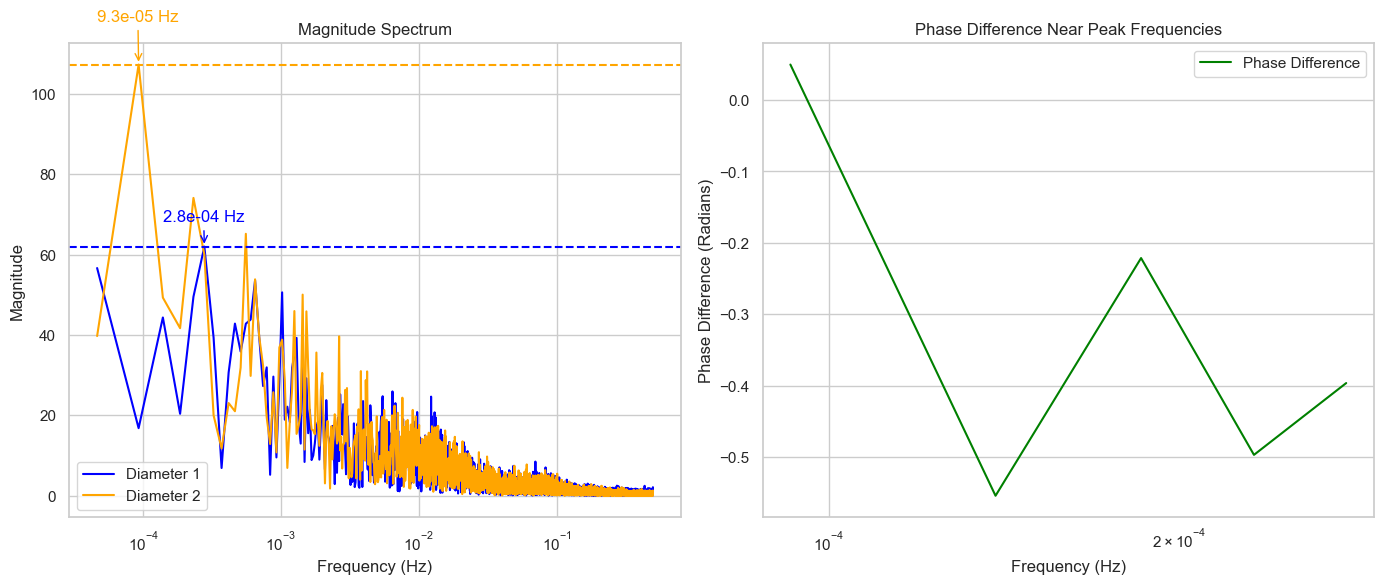

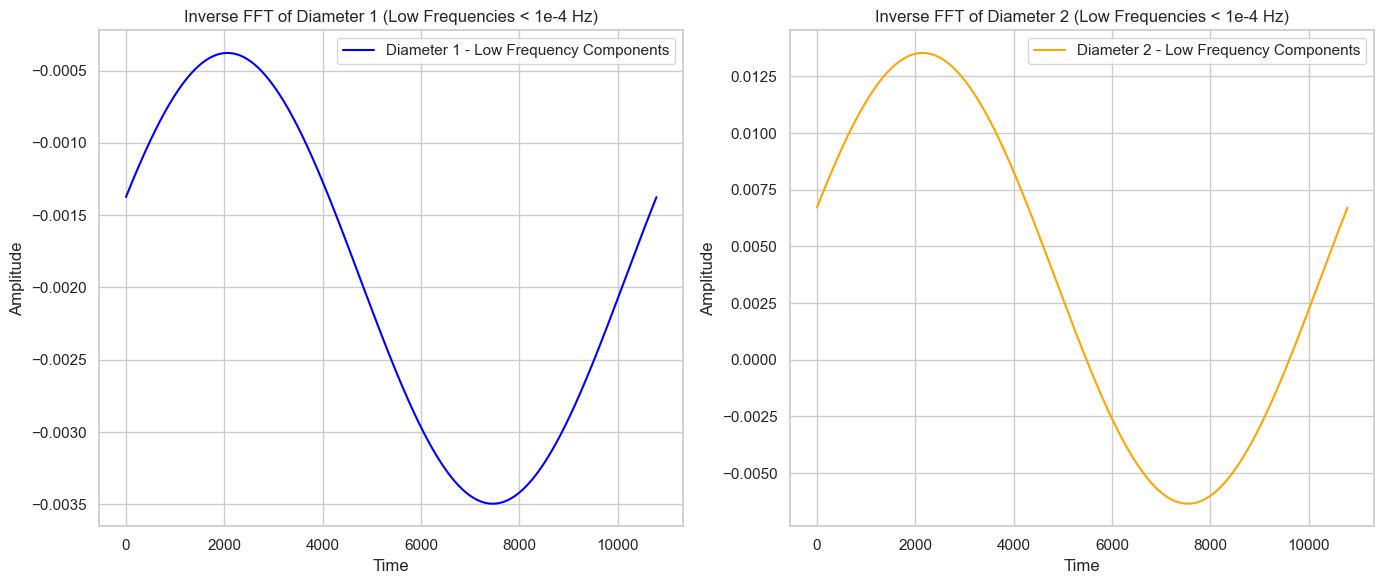

Starting preprocessing and analysis for PETG_04:
Preprocessing and analyzing for the whole dataset


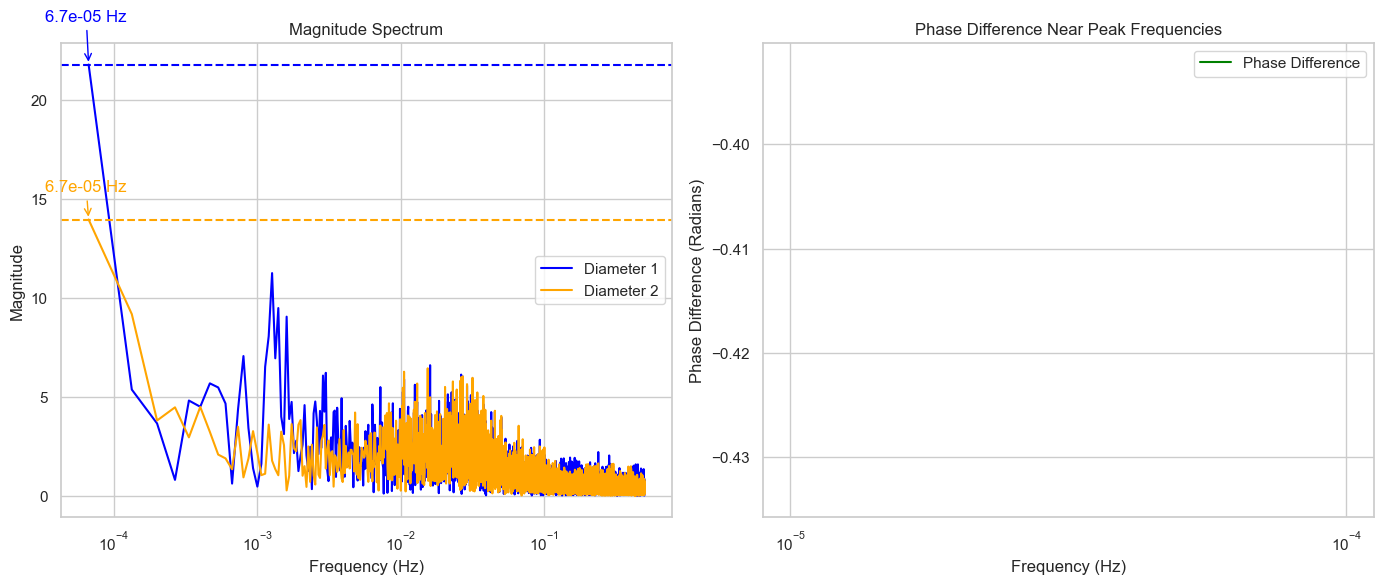

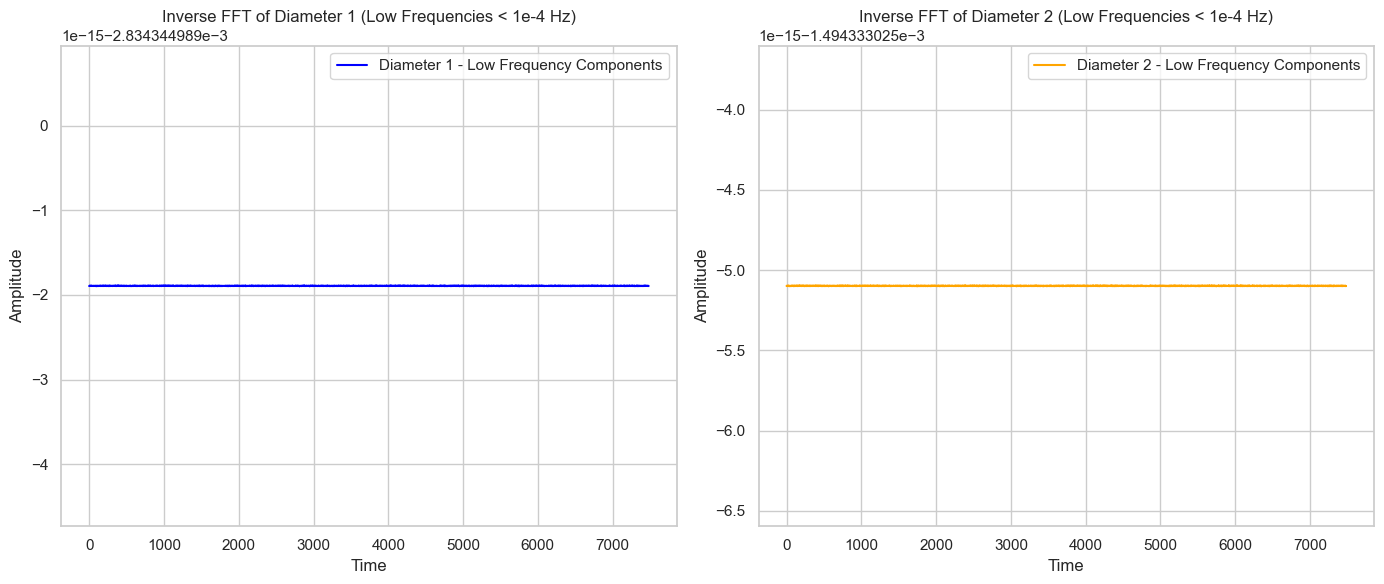

Starting preprocessing and analysis for PETG_02:
Preprocessing and analyzing for the whole dataset


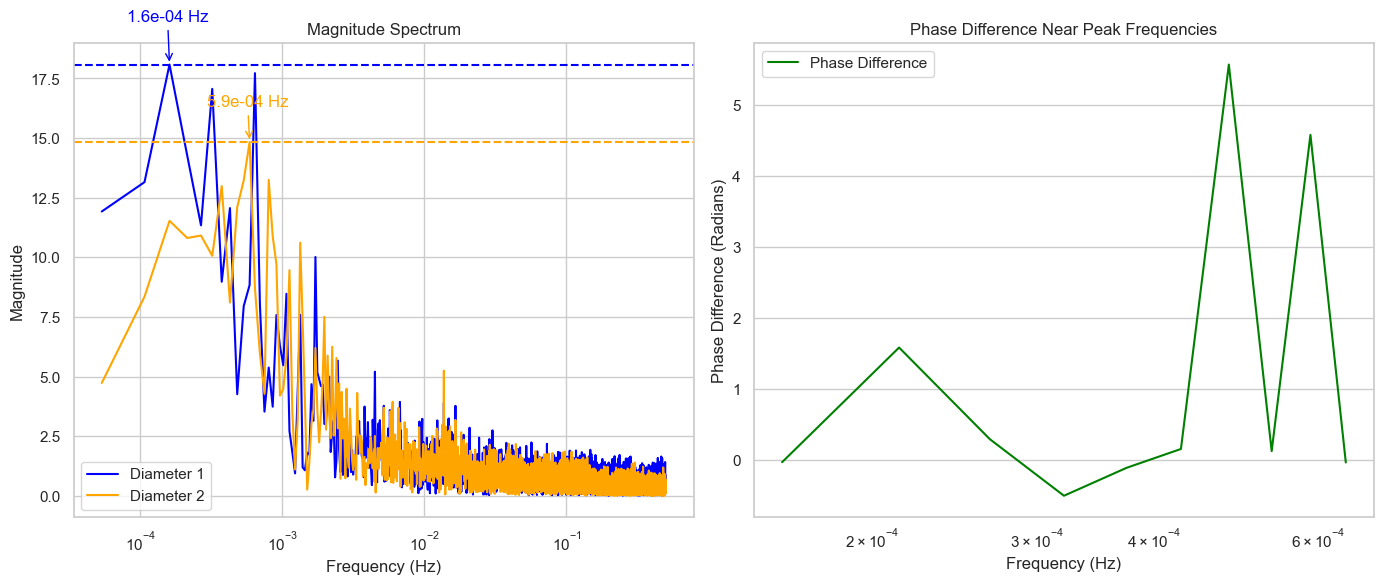

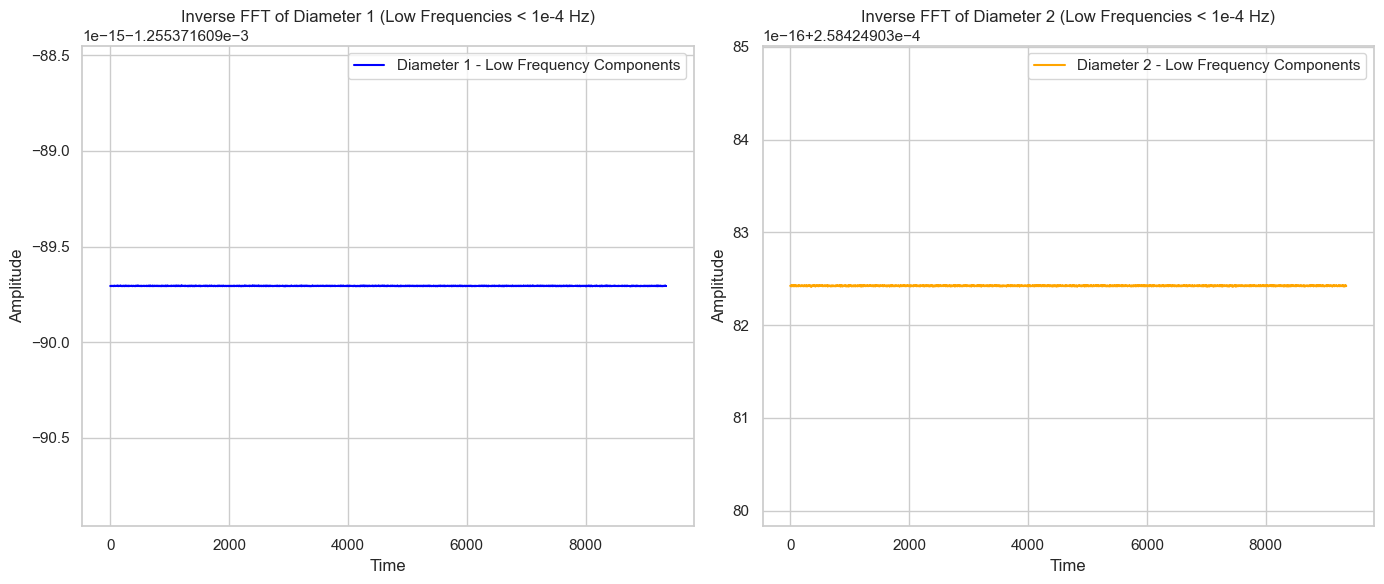

In [194]:
def inverse_fft_and_plot_low_freq_components(df):
    if 'diameter_1' not in df.columns or 'diameter_2' not in df.columns:
        print("Necessary columns are missing in the DataFrame.")
        return

    # Fourier Transform
    fft_diameter1 = np.fft.fft(df['diameter_1'].dropna())
    fft_diameter2 = np.fft.fft(df['diameter_2'].dropna())

    # Frequencies corresponding to the FFT outputs
    freq = np.fft.fftfreq(len(fft_diameter1), d=1)  # Assume d is the sample spacing

    # Ensure only positive frequencies are used for log-scale plotting
    positive_freq_indices = freq > 0
    freq = freq[positive_freq_indices]
    fft_diameter1 = fft_diameter1[positive_freq_indices]
    fft_diameter2 = fft_diameter2[positive_freq_indices]

    # Filter to keep only frequencies < 1e-4 Hz
    low_freq_indices = freq < 1e-4
    low_freq_fft_diameter1 = np.zeros_like(fft_diameter1)
    low_freq_fft_diameter2 = np.zeros_like(fft_diameter2)

    # Populate only the low frequency components
    low_freq_fft_diameter1[low_freq_indices] = fft_diameter1[low_freq_indices]
    low_freq_fft_diameter2[low_freq_indices] = fft_diameter2[low_freq_indices]

    # Inverse Fourier Transform
    ifft_diameter1 = np.fft.ifft(low_freq_fft_diameter1)
    ifft_diameter2 = np.fft.ifft(low_freq_fft_diameter2)

    # Plotting
    time = np.arange(len(ifft_diameter1))  # Time vector for x-axis

    plt.figure(figsize=(14, 6))
    plt.subplot(121)
    plt.plot(time, ifft_diameter1.real, label='Diameter 1 - Low Frequency Components', color='blue')  # Plotting real part
    plt.title('Inverse FFT of Diameter 1 (Low Frequencies < 1e-4 Hz)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()

    plt.subplot(122)
    plt.plot(time, ifft_diameter2.real, label='Diameter 2 - Low Frequency Components', color='orange')  # Plotting real part
    plt.title('Inverse FFT of Diameter 2 (Low Frequencies < 1e-4 Hz)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Usage example within a preprocessing and analysis function
def preprocess_and_analyze_with_ifft(data_dict):
    if isinstance(data_dict, dict):
        for segment_name, segment_df in data_dict.items():
            print(f"Preprocessing and analyzing for: {segment_name}")
            cleaned_df = remove_outliers(segment_df, 'diameter_1')
            cleaned_df = remove_outliers(cleaned_df, 'diameter_2')
            processed_df = apply_rolling_average_and_downsample(cleaned_df, downsample_factor=10, rolling_avg_resolution=50)
            analyze_periodicity_and_phase(processed_df)
            inverse_fft_and_plot_low_freq_components(processed_df)
    else:
        print("Preprocessing and analyzing for the whole dataset")
        cleaned_df = remove_outliers(data_dict, 'diameter_1')
        cleaned_df = remove_outliers(cleaned_df, 'diameter_2')
        processed_df = apply_rolling_average_and_downsample(cleaned_df, downsample_factor=10, rolling_avg_resolution=50)
        analyze_periodicity_and_phase(processed_df)
        inverse_fft_and_plot_low_freq_components(processed_df)

# Example usage
for name, data in dataframes.items():
    print(f"Starting preprocessing and analysis for {name}:")
    preprocess_and_analyze_with_ifft(data)

In [128]:
def plot_diameters(df, title, use_rolling_average):    
    plt.figure(figsize=(10, 5))
    x = df['length_ra'] if use_rolling_average else df['length']
    y1 = df['diameter_1_ra'] if use_rolling_average else df['diameter_1']
    y2 = df['diameter_2_ra'] if use_rolling_average else df['diameter_2']
    y_avg = df['diameter_avg_ra'] if use_rolling_average else df['diameter_avg']

    sns.scatterplot(x=x, y=y1, alpha=0.7, label='Diameter 1', color='blue', s=1)
    sns.scatterplot(x=x, y=y2, alpha=0.7, label='Diameter 2', color='green', s=1)
    plt.scatter(x, y_avg, alpha=0.7, label='Average Diameter', color='purple', s=1, marker='^')

    plt.title(title)
    plt.xlabel('Length')
    plt.ylabel('Diameter')
    plt.legend()
    plt.grid(True)
    # Suppressing warnings related to creating legends with large datasets
    warnings.simplefilter("ignore", category=UserWarning)
    plt.show()

# Loop to process dataframes
for name, item in dataframes.items():
    if segment_switch and isinstance(item, dict):
        for segment_name, segment_df in item.items():
            print(f"Processing {name} - {segment_name}")
            segment_df = remove_outliers(segment_df, 'diameter_1')
            segment_df = remove_outliers(segment_df, 'diameter_2')
            segment_df['diameter_avg'] = segment_df[['diameter_1', 'diameter_2']].mean(axis=1)
            if rolling_average_switch:
                segment_df = apply_rolling_average_and_downsample(segment_df, down_sample_value, rolling_avg_resolution)
            dataframes[name][segment_name] = segment_df  # Update the segment
            print(segment_df['diameter_avg'].describe())
            plot_diameters(segment_df, f"{name} - {segment_name}: Diameter vs. Length", rolling_average_switch)
    elif isinstance(item, pd.DataFrame):
        print(f"Processing {name}")
        item = remove_outliers(item, 'diameter_1')
        item = remove_outliers(item, 'diameter_2')
        item['diameter_avg'] = item[['diameter_1', 'diameter_2']].mean(axis=1)
        if rolling_average_switch:
            item = apply_rolling_average_and_downsample(item, down_sample_value, rolling_avg_resolution)
        dataframes[name] = item  # Update the DataFrame
        print(item['diameter_avg'].describe())
        plot_diameters(item, f"{name}: Diameter vs. Length", rolling_average_switch)
    else:
        print(f"Unsupported data structure in dataframes[{name}]")

Processing PETG_01
count    189328.000000
mean          1.766622
std           0.011377
min           1.712948
25%           1.758767
50%           1.766728
75%           1.774631
max           1.811865
Name: diameter_avg, dtype: float64


KeyboardInterrupt: 

In [93]:
processed_dataframes = {}
for name, item in dataframes.items():
    if segment_switch and isinstance(item, dict):  # Check if dataframes are segmented
        for segment_name, df in item.items():
            if rolling_average_switch:
                df = segment_df = apply_rolling_average_and_downsample(df, down_sample_value, rolling_avg_resolution)
            
            std = df['diameter_avg'].std()
            n = df['diameter_avg'].count()
            df['segment'] = segment_name  # Adding segment identifier
            df['group'] = name  # Group by filament type
            processed_dataframes[f"{name}_{segment_name}"] = df
    elif isinstance(item, pd.DataFrame):  # Handle non-segmented dataframes
        if rolling_average_switch:
            item = segment_df = apply_rolling_average_and_downsample(item, down_sample_value, rolling_avg_resolution)

        std = item['diameter_avg'].std()
        n = item['diameter_avg'].count()
        item['group'] = name  # Group by filament type
        processed_dataframes[name] = item
    else:
        print(f"Unsupported data structure in dataframes[{name}]")

# Concatenate all the data into a single DataFrame
combined_df = pd.concat(processed_dataframes.values(), ignore_index=True)

if segment_switch:
    warnings.simplefilter("ignore", category=FutureWarning)
    
    # Ensure combined_df has the necessary columns and data
    combined_df['segment'] = pd.Categorical(combined_df['segment'], 
                                            categories=['first', 'second', 'third', 'fourth', 'fifth', 'sixth'], 
                                            ordered=True)
    
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=combined_df, x='segment', y='diameter_avg', hue='group', marker='o')
    plt.title('Interaction Plot for Filament Type and Section Within')
    plt.xlabel('Section')
    plt.ylabel('Average Diameter')
    plt.xticks(rotation=45)
    plt.legend(title='Group')
    plt.tight_layout()
    plt.show()

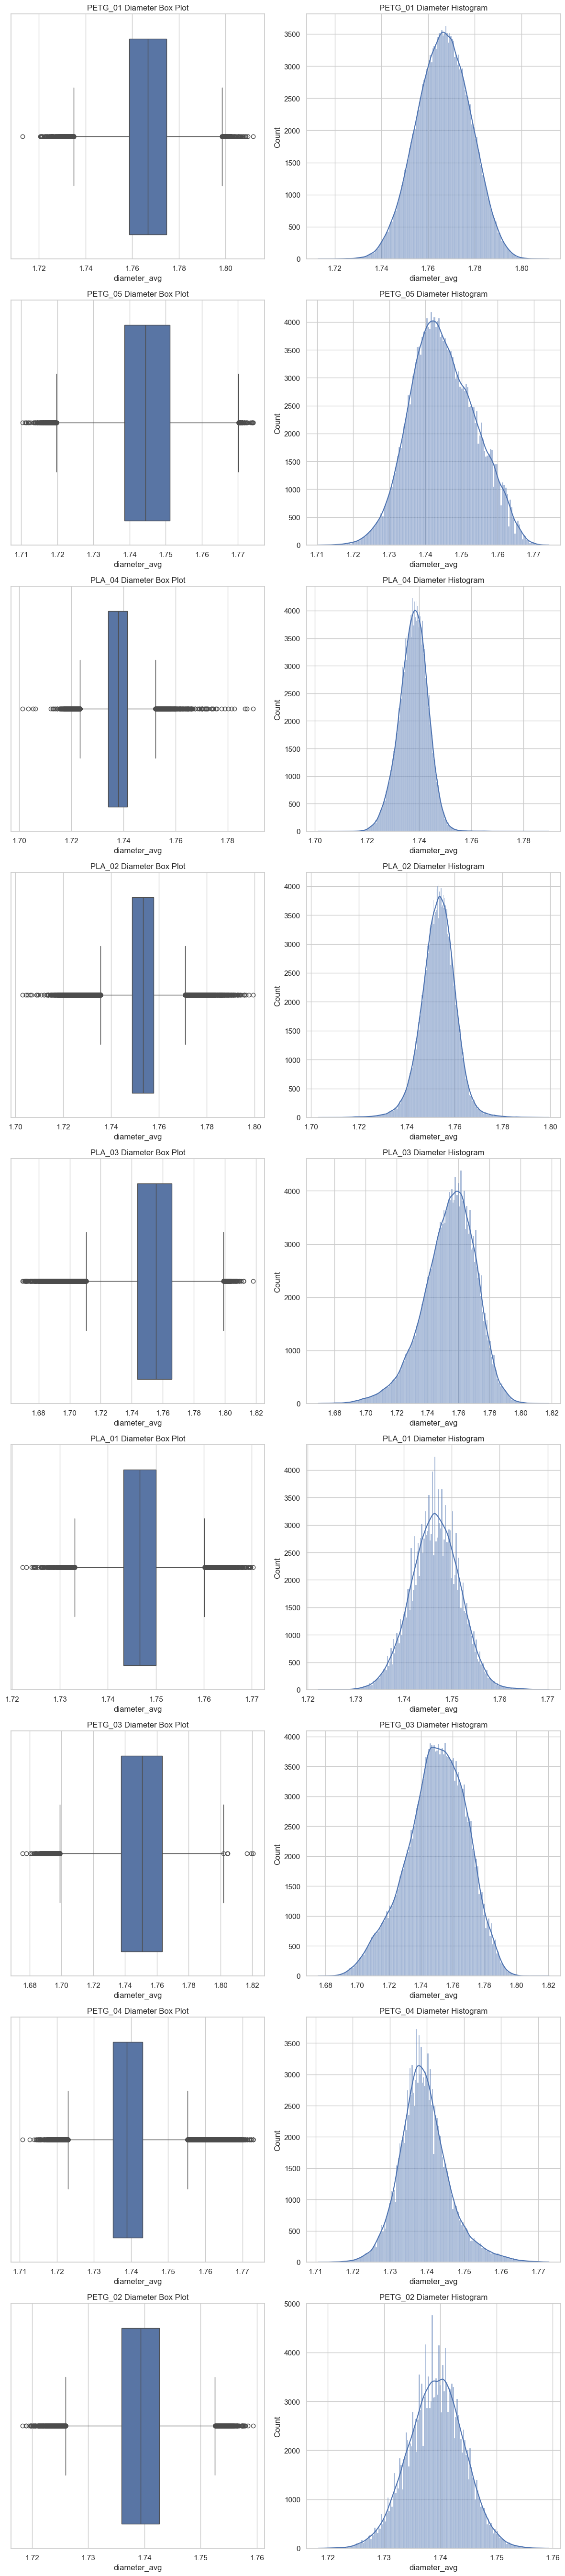

In [94]:
sns.set(style="whitegrid")

# Function to create plots for a given DataFrame
def create_plots(df, axs, row_index, name):
    if rolling_average_switch:
        # Use the rolling average DataFrame if the switch is on
        df = apply_rolling_average_and_downsample(df, down_sample_value, rolling_avg_resolution)

    sns.boxplot(x=df['diameter_avg'], ax=axs[row_index, 0]).set_title(f'{name} Diameter Box Plot')

    sns.histplot(df['diameter_avg'], kde=True, ax=axs[row_index, 1]).set_title(f'{name} Diameter Histogram')

num_plots = sum(len(v) for v in dataframes.values() if isinstance(v, dict)) if segment_switch else len(dataframes)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    fig, axs = plt.subplots(num_plots, 2, figsize=(12, 6 * num_plots))
    row_index = 0
    for name, item in dataframes.items():
        if segment_switch and isinstance(item, dict):
            for segment_name, df_segment in item.items():
                plot_title = f"{name} - {segment_name}"
                create_plots(df_segment, axs, row_index, plot_title)
                row_index += 1
        elif isinstance(item, pd.DataFrame):
            plot_title = f"{name}"
            create_plots(item, axs, row_index, plot_title)
            row_index += 1
        else:
            print(f"Unsupported data structure in dataframes[{name}]")
    plt.tight_layout()
    plt.show()


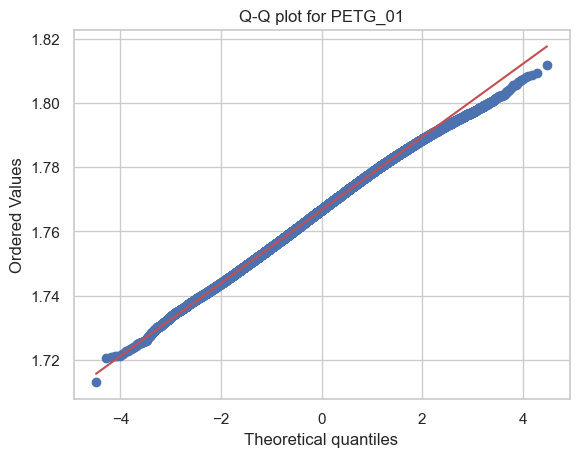

PETG_01 - Skewness: -0.07203562423342409, Kurtosis: -0.23154691316112208


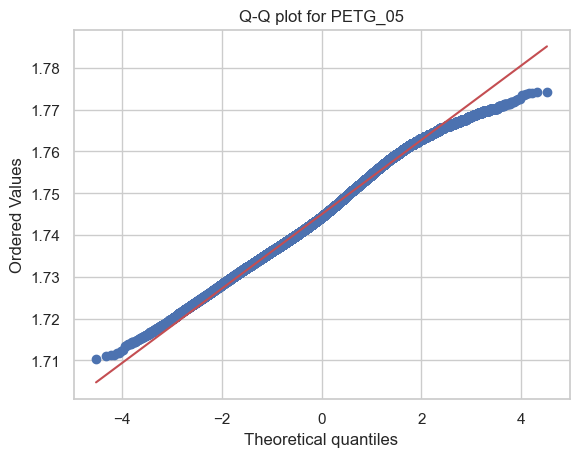

PETG_05 - Skewness: 0.12702811241210438, Kurtosis: -0.3330031648815064


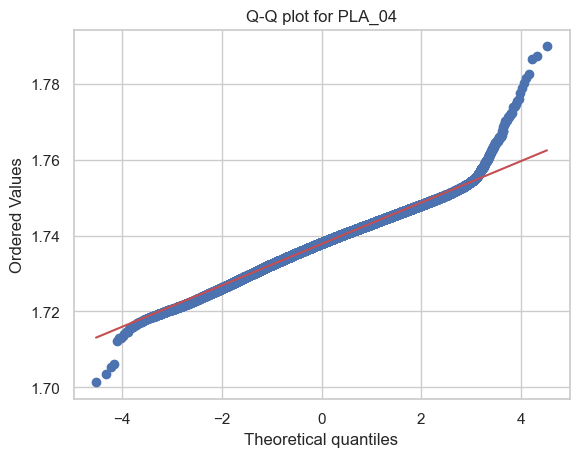

PLA_04 - Skewness: -0.1439309501624715, Kurtosis: 0.5412818445386205


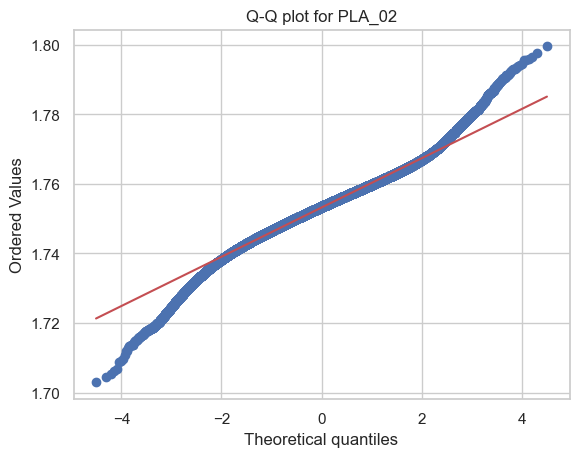

PLA_02 - Skewness: -0.16917241737061062, Kurtosis: 1.5073504992142963


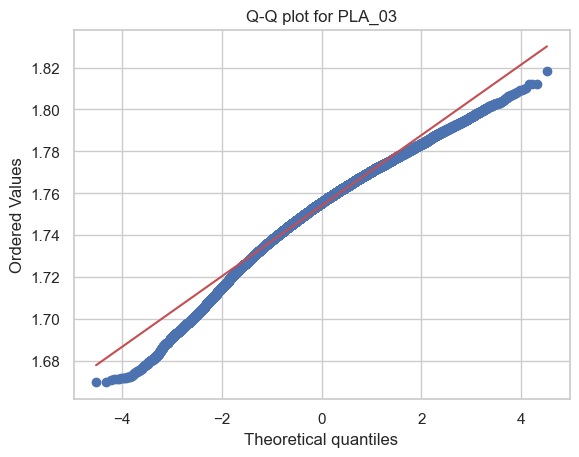

PLA_03 - Skewness: -0.5492307307181943, Kurtosis: 0.5899785470900776


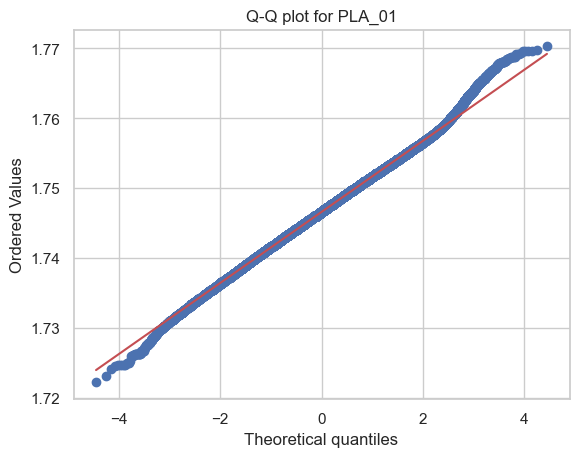

PLA_01 - Skewness: -0.0008206567109793132, Kurtosis: 0.2527816142105159


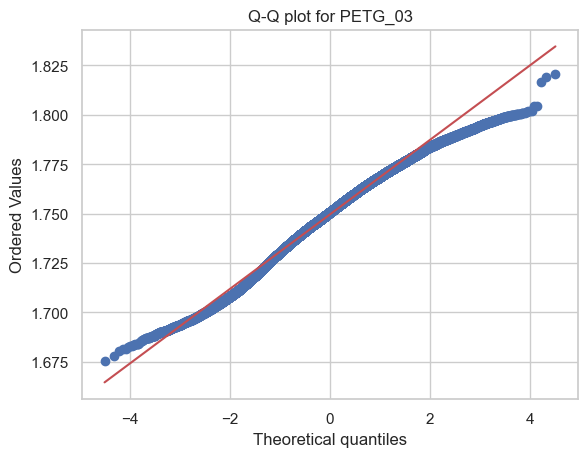

PETG_03 - Skewness: -0.3311158978636757, Kurtosis: -0.17261899403094372


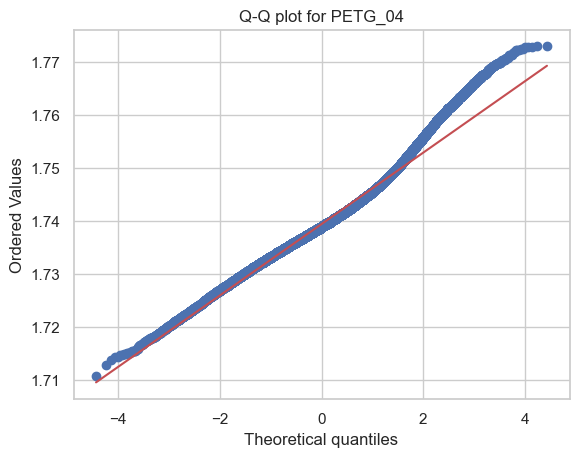

PETG_04 - Skewness: 0.5619393400630438, Kurtosis: 1.1356214196385372


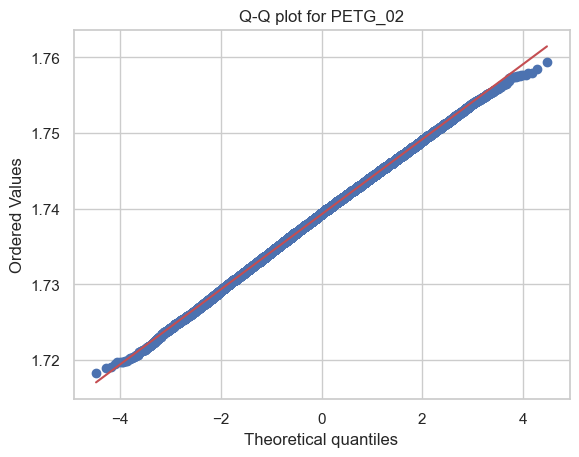

PETG_02 - Skewness: -0.07213840274323605, Kurtosis: -0.005844551319699409


In [95]:
def create_plots(df, axs, row_index, name):
    if rolling_average_switch:
        # Use the rolling average DataFrame if the switch is on
        df = apply_rolling_average_and_downsample(df, down_sample_value, rolling_avg_resolution)

    sns.boxplot(x=df['diameter_avg'], ax=axs[row_index, 0]).set_title(f'{name} Diameter Box Plot')
    sns.histplot(df['diameter_avg'], kde=True, ax=axs[row_index, 1]).set_title(f'{name} Diameter Histogram')
    
    # Add a Q-Q plot
    fig, ax = plt.subplots()
    stats.probplot(df['diameter_avg'].dropna(), dist="norm", plot=ax)
    ax.set_title(f'Q-Q plot for {name}')
    plt.show()

    # Calculate and display skewness and kurtosis
    skewness = df['diameter_avg'].skew()
    kurtosis = df['diameter_avg'].kurtosis()
    print(f"{name} - Skewness: {skewness}, Kurtosis: {kurtosis}")

    # Optional: You could still display Shapiro-Wilk results but take them with a grain of salt for large datasets
    if len(df['diameter_avg'].dropna()) < 5000:  # Limit to reasonable size for Shapiro-Wilk
        stat, p = shapiro(df['diameter_avg'].dropna())
        print(f"Normality test for {name}: Statistics={stat:.3f}, p-value={p:.3g}")
        if p > 0.05:
            print(f"The diameter data for {name} looks normally distributed (fail to reject H0)")
        else:
            print(f"The diameter data for {name} does not look normally distributed (reject H0)")

row_index = 0
for group_name, segments in dataframes.items():
    if isinstance(segments, dict):  # Checks if the value is a nested dictionary
        for segment_name, df in segments.items():
            plot_name = f"{group_name} - {segment_name}"  # Combines group and segment name for labeling
            create_plots(df, axs, row_index, plot_name)
            row_index += 1
    elif isinstance(segments, pd.DataFrame):  # Direct DataFrame
        create_plots(segments, axs, row_index, group_name)
        row_index += 1
    else:
        print(f"Unsupported data structure in dataframes[{group_name}]")

# Kruskal-Wallis Tests

## Evaluating difference in medians across groups against baseline, within sections of groups against each other, andwithin sections of groups against baseline

### Baseline = 1.75 mm
### Practical significance is set at a 0.01 mm difference, but can be changed

In [49]:
def epsilon_squared(H, n_total):
    """ Calculate epsilon squared for effect size. """
    return H * (n_total - 1) / (n_total ** 2 - 1)

def run_pairwise_comparisons(dataframes, segment_switch, practical_threshold=0.01):
    segments = {}  # Will hold the data for each segment or group for comparison
    
    # Collect data for Kruskal-Wallis test
    if segment_switch:
        # Handle segmented data
        for group_name, segments_dict in dataframes.items():
            for segment_name, df in segments_dict.items():
                key = f"{group_name}_{segment_name}"
                segments[key] = df['diameter_avg'].dropna().values
    else:
        # Handle whole group data
        for group_name, df in dataframes.items():
            segments[group_name] = df['diameter_avg'].dropna().values
    
    # Perform Kruskal-Wallis test across all segments/groups
    datasets = list(segments.values())
    labels = list(segments.keys())
    if len(datasets) > 1:
        stat, p = stats.kruskal(*datasets)
        n_total = sum(len(data) for data in datasets)
        eps_sq = epsilon_squared(stat, n_total)
        print(f"Kruskal-Wallis Test across {'segments' if segment_switch else 'groups'}:")
        print(f"Statistic: {stat}, p-value: {p:.3f}, epsilon squared: {eps_sq:.3f}\n")
        
        # Perform pairwise comparisons
        comparisons = []
        p_values = []
        actual_differences = []
        medians = {label: np.median(data) for label, data in segments.items()}
        for (data1, label1), (data2, label2) in itertools.combinations(zip(datasets, labels), 2):
            stat, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
            comparisons.append((label1, label2))
            p_values.append(p)
            median_diff = abs(medians[label1] - medians[label2])
            actual_differences.append(median_diff)
        
        reject, p_adjusted, _, _ = multipletests(p_values, method='bonferroni')
        print("Pairwise Comparisons:")
        for (label1, label2), diff, p, p_adj, rej in zip(comparisons, actual_differences, p_values, p_adjusted, reject):
            print(f"{label1} vs {label2}:")
            print(f"  Median Difference: {diff:.4f}")
            if diff >= practical_threshold:
                print("  The difference is practically significant.")
            else:
                print("  The difference is not practically significant.")
        print("\n")
    else:
        print(f"Not enough data to perform Kruskal-Wallis test across {'segments' if segment_switch else 'groups'}.\n")

run_pairwise_comparisons(dataframes, segment_switch, practical_threshold=0.01)

Kruskal-Wallis Test across segments:
Statistic: 887413.3682906936, p-value: 0.000, epsilon squared: 0.500

Pairwise Comparisons:
PETG_01_first vs PETG_01_second:
  Median Difference: 0.0026
  The difference is not practically significant.
PETG_01_first vs PETG_01_third:
  Median Difference: 0.0026
  The difference is not practically significant.
PETG_01_first vs PETG_01_fourth:
  Median Difference: 0.0018
  The difference is not practically significant.
PETG_01_first vs PETG_01_fifth:
  Median Difference: 0.0019
  The difference is not practically significant.
PETG_01_first vs PETG_01_sixth:
  Median Difference: 0.0078
  The difference is not practically significant.
PETG_01_first vs PETG_05_first:
  Median Difference: 0.0191
  The difference is practically significant.
PETG_01_first vs PETG_05_second:
  Median Difference: 0.0240
  The difference is practically significant.
PETG_01_first vs PETG_05_third:
  Median Difference: 0.0141
  The difference is practically significant.
PETG_01_

In [50]:
def run_wilcoxon_tests(dataframes, segment_switch, hypothesized_median=1.75):
    """Run Wilcoxon signed-rank tests against a hypothesized median for each group or segment."""
    results = {}  # This will store the test results

    # Collect data and perform the Wilcoxon signed-rank test
    if segment_switch:
        # Handle segmented data
        for group_name, segments_dict in dataframes.items():
            for segment_name, df in segments_dict.items():
                key = f"{group_name}_{segment_name}"
                if 'diameter_avg' in df.columns:
                    data = df['diameter_avg'].dropna().values
                    if len(data) > 0:
                        stat, p = stats.wilcoxon(data - hypothesized_median)
                        median_diff = np.median(data) - hypothesized_median
                        results[key] = (stat, p, median_diff)
    else:
        # Handle whole group data
        for group_name, df in dataframes.items():
            if 'diameter_avg' in df.columns:
                data = df['diameter_avg'].dropna().values
                if len(data) > 0:
                    stat, p = stats.wilcoxon(data - hypothesized_median)
                    median_diff = np.median(data) - hypothesized_median
                    results[group_name] = (stat, p, median_diff)

    # Output the results
    print("Wilcoxon Signed-Rank Test Results Against Hypothesized Median:")
    for label, (stat, p, diff) in results.items():
        print(f"{label}:")
        print(f"  Test Statistic: {stat}, p-value: {p:.5f}")
        print(f"  Median Difference from Hypothesized Median: {diff:.4f}")
        if abs(diff) >= 0.01:  # Check against a practical significance level, if needed
            print("  The difference is considered practically significant.")
        else:
            print("  The difference is not considered practically significant.")
        print("\n")

# Example of calling the function with your data structure
run_wilcoxon_tests(dataframes, segment_switch, hypothesized_median=1.75)

Wilcoxon Signed-Rank Test Results Against Hypothesized Median:
PETG_01_first:
  Test Statistic: 15477471.0, p-value: 0.00000
  Median Difference from Hypothesized Median: 0.0158
  The difference is considered practically significant.


PETG_01_second:
  Test Statistic: 22522274.0, p-value: 0.00000
  Median Difference from Hypothesized Median: 0.0132
  The difference is considered practically significant.


PETG_01_third:
  Test Statistic: 18659379.0, p-value: 0.00000
  Median Difference from Hypothesized Median: 0.0132
  The difference is considered practically significant.


PETG_01_fourth:
  Test Statistic: 5096683.0, p-value: 0.00000
  Median Difference from Hypothesized Median: 0.0176
  The difference is considered practically significant.


PETG_01_fifth:
  Test Statistic: 4839055.0, p-value: 0.00000
  Median Difference from Hypothesized Median: 0.0177
  The difference is considered practically significant.


PETG_01_sixth:
  Test Statistic: 1913326.0, p-value: 0.00000
  Median Di

# CAE

In [96]:
target_diameter = 1.75
measurement_increment = 1.49  # each measurement represents 1.49 mm

# Define weight and cost for each group
weights = {
    'PLA_01': 1,
    'PETG_01': 1.0,  
    'PETG_02': 1.0, 
    'PETG_03': 1.0, 
    'PETG_04': 1.0, 
    'PETG_05': 1.0,
    'PLA_02': 1.0, 
    'PLA_03': 1.0, 
    'PLA_04': 1.0 
}

cost_per_group = {
    'PETG_01': 45.60,  
    'PETG_02': 24.99, 
    'PETG_03': 45.60, 
    'PETG_04': 21.98, 
    'PETG_05': 24.99, 
    'PLA_01': 66.67,
    'PLA_02': 24.99, 
    'PLA_03': 20.87, 
    'PLA_04': 20.87 
}

def calculate_metrics(df, target, weight, cost, measurement_increment):
    cae = df['diameter_avg'].sub(target).abs().sum()
    meters_per_measurement = measurement_increment / 1000
    total_meters = len(df) * meters_per_measurement
    
    normalized_by_length = cae / total_meters if total_meters else cae
    normalized_by_weight = cae / weight if weight else cae
    normalized_by_cost = cae / cost if cost else cae

    return normalized_by_length, normalized_by_weight, normalized_by_cost

# Calculate and normalize CAE for each group or segment
cae_results = []
if segment_switch:
    for (group, segment), group_df in combined_df.groupby(['group', 'segment']):
        weight = weights.get(group, 1)  # default to 1 kg if not specified
        cost = cost_per_group.get(group, 1)  # default to 1 dollar if not specified
        norm_length, norm_weight, norm_cost = calculate_metrics(group_df, target_diameter, weight, cost, measurement_increment)
        cae_results.append({'Group': group, 'Segment': segment, 'Cost': cost, 'Normalized CAE': norm_cost})
else:
    for group, group_df in combined_df.groupby('group'):
        weight = weights.get(group, 1)
        cost = cost_per_group.get(group, 1)
        norm_length, norm_weight, norm_cost = calculate_metrics(group_df, target_diameter, weight, cost, measurement_increment)
        cae_results.append({'Group': group, 'Segment': 'overall', 'Cost': cost, 'Normalized CAE': norm_cost})

# Convert results to DataFrame
results_df = pd.DataFrame(cae_results)

In [174]:
def calculate_metrics(df, target, weight, cost, measurement_increment):
    cae = df['diameter_avg'].sub(target).abs().sum()
    meters_per_measurement = measurement_increment / 1000
    total_meters = len(df) * meters_per_measurement
    
    normalized_by_length = cae / total_meters if total_meters else cae
    normalized_by_weight = cae / weight if weight else cae
    normalized_by_cost = cae / cost if cost else cae
    dollars_per_kg = cost / weight if weight != 0 else 0

    return normalized_by_length, normalized_by_weight, normalized_by_cost, dollars_per_kg

# Initialize the DataFrame and process data based on segment_switch
output_directory = "segmented CAE" if segment_switch else "Overall CAE"
os.makedirs(output_directory, exist_ok=True)
all_results_df = pd.DataFrame()

group_dollars_kg = []
group_cae_meter = []

if segment_switch:
    segment_order = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth']
    for (group, segment), group_df in combined_df.groupby(['group', 'segment']):
        weight = weights.get(group, 1)
        cost = cost_per_group.get(group, 1)
        norm_length, norm_weight, norm_cost, dollars_per_kg = calculate_metrics(group_df, target_diameter, weight, cost, measurement_increment)
        new_row = pd.DataFrame({
            'Group': [group],
            'Segment': [segment],
            'Normalized by Length': [norm_length],
            'Normalized by Weight': [norm_weight],
            'Normalized by Cost': [norm_cost]
        })
        all_results_df = pd.concat([all_results_df, new_row], ignore_index=True)
        group_dollars_kg.append(dollars_per_kg)
        group_cae_meter.append(norm_length)
else:
    segment_order = ['overall']  # No segments, just an overall grouping
    for group, group_df in combined_df.groupby('group'):
        weight = weights.get(group, 1)
        cost = cost_per_group.get(group, 1)
        norm_length, norm_weight, norm_cost, dollars_per_kg = calculate_metrics(group_df, target_diameter, weight, cost, measurement_increment)
        new_row = pd.DataFrame({
            'Group': [group],
            'Segment': ['overall'],
            'Normalized by Length': [norm_length],
            'Normalized by Weight': [norm_weight],
            'Normalized by Cost': [norm_cost]
        })
        all_results_df = pd.concat([all_results_df, new_row], ignore_index=True)
        group_dollars_kg.append(dollars_per_kg)
        group_cae_meter.append(norm_length)

# Set 'Segment' as a categorical type with a defined order and sort the DataFrame
all_results_df['Segment'] = pd.Categorical(all_results_df['Segment'], categories=segment_order, ordered=True)
all_results_df.sort_values(by=['Group', 'Segment'], inplace=True)

# Save results to CSV files in the specified directory
for group in all_results_df['Group'].unique():
    filename = os.path.join(output_directory, f"{group}_deviations.csv")
    group_df = all_results_df[all_results_df['Group'] == group]
    group_df.to_csv(filename, index=False)
    print(f"Saved results for {group} to {filename}")

all_in_one_filename = os.path.join(output_directory, "All_Deviations.csv")
all_results_df.to_csv(all_in_one_filename, index=False)


Saved results for PETG_01 to Overall CAE\PETG_01_deviations.csv
Saved results for PETG_02 to Overall CAE\PETG_02_deviations.csv
Saved results for PETG_03 to Overall CAE\PETG_03_deviations.csv
Saved results for PETG_04 to Overall CAE\PETG_04_deviations.csv
Saved results for PETG_05 to Overall CAE\PETG_05_deviations.csv
Saved results for PLA_01 to Overall CAE\PLA_01_deviations.csv
Saved results for PLA_02 to Overall CAE\PLA_02_deviations.csv
Saved results for PLA_03 to Overall CAE\PLA_03_deviations.csv
Saved results for PLA_04 to Overall CAE\PLA_04_deviations.csv


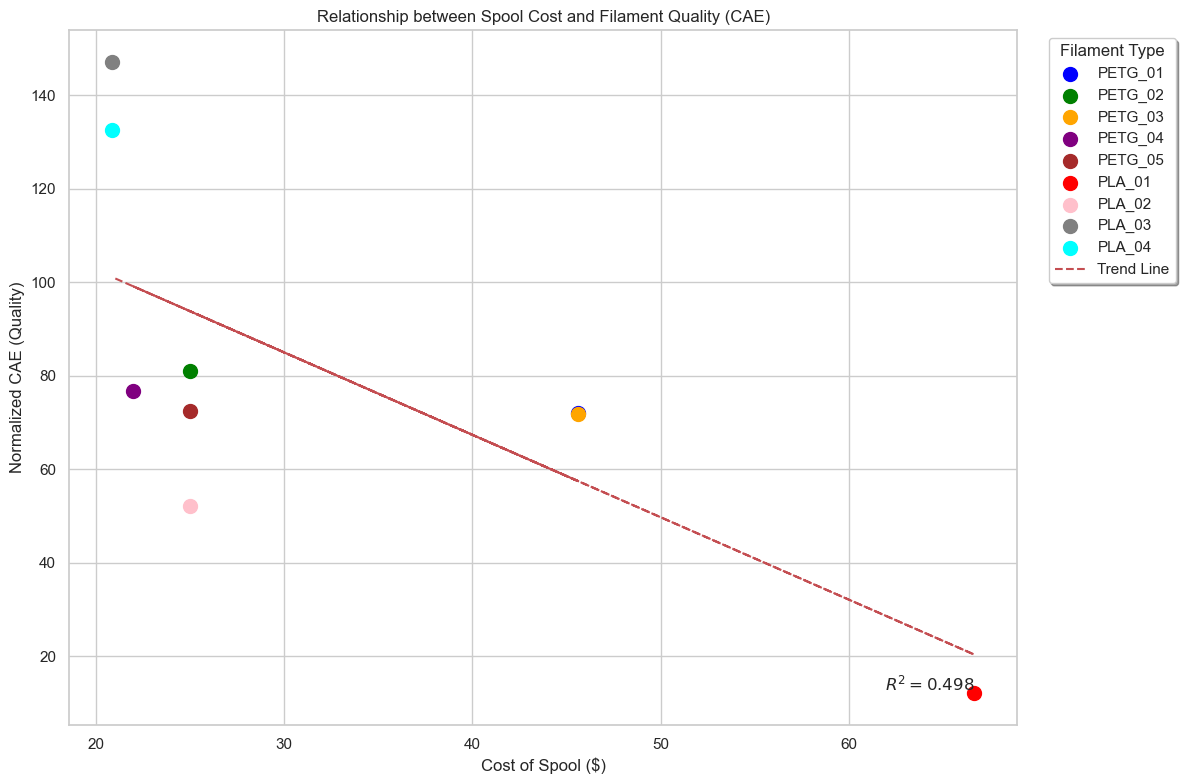

In [99]:
# Create the plot
plt.figure(figsize=(12, 8))

# Scatter plot each group with its own color
for group in results_df['Group'].unique():
    subset = results_df[results_df['Group'] == group]
    plt.scatter(subset['Cost'], subset['Normalized CAE'], color=group_colors[group], label=group, s=100)

# Fit and plot a regression line
x = results_df['Cost']
y = results_df['Normalized CAE']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label='Trend Line')

# Calculate R^2
correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

# Add R^2 value to the plot
plt.text(x.max(), y.min(), f'$R^2 = {r_squared:.3f}$', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

plt.title('Relationship between Spool Cost and Filament Quality (CAE)')
plt.xlabel('Cost of Spool ($)')
plt.ylabel('Normalized CAE (Quality)')
plt.grid(True)

# Place the legend outside the plot
plt.legend(title='Filament Type', loc='upper center', bbox_to_anchor=(1.1, 1), shadow=True, ncol=1)

plt.tight_layout()
plt.show()

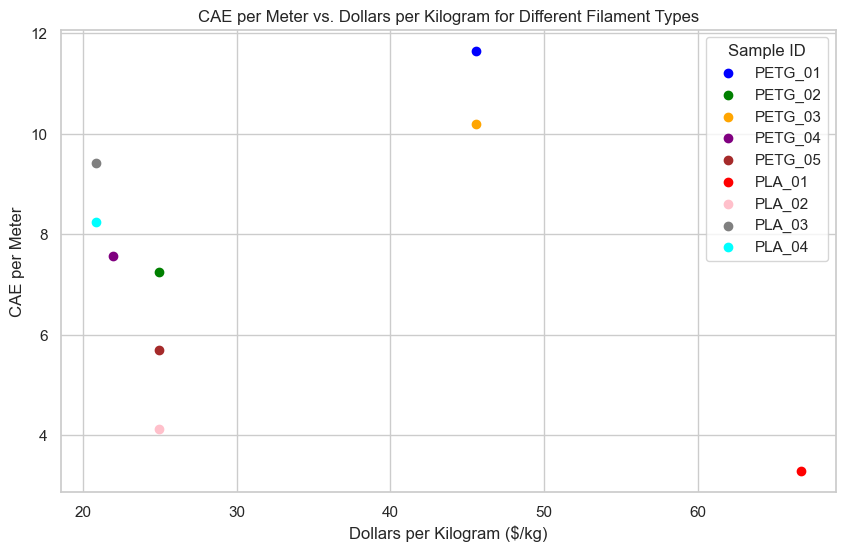

In [98]:
group_colors = {
    'PLA_01': 'red',
    'PETG_01': 'blue',
    'PETG_02': 'green',
    'PETG_03': 'orange',
    'PETG_04': 'purple',
    'PETG_05': 'brown',
    'PLA_02': 'pink',
    'PLA_03': 'gray',
    'PLA_04': 'cyan'
}

plt.figure(figsize=(10, 6))

# Collect group names for labels
group_names = all_results_df['Group'].unique()

# Plot each data point and label them
for i, group in enumerate(group_names):
    # Extract data for each group
    dollars_kg = [group_dollars_kg[j] for j, g in enumerate(all_results_df['Group']) if g == group]
    cae_meter = [group_cae_meter[j] for j, g in enumerate(all_results_df['Group']) if g == group]

    plt.scatter(dollars_kg, cae_meter, color=group_colors[group], label=group)

plt.title('CAE per Meter vs. Dollars per Kilogram for Different Filament Types')
plt.xlabel('Dollars per Kilogram ($/kg)')
plt.ylabel('CAE per Meter')
plt.legend(title='Sample ID')
plt.grid(True)
plt.show()

In [185]:
def create_kde_plot(dataframes, results_df, normalization_field, color_map, plot_title):
    fig = go.Figure()

    # Sort results by the chosen normalization field in descending order
    results_df = results_df.sort_values(by=normalization_field, ascending=False)

    # Create a colormap that darkens with increasing index
    cmap = plt.get_cmap(color_map)
    norm = plt.Normalize(vmin=results_df[normalization_field].min(), vmax=results_df[normalization_field].max())

    for index, row in results_df.iterrows():
        group = row['Group']
        segment = row['Segment']
        label = f"{group} - {segment}" if segment != 'overall' else group
        df_key = (group, segment) if segment != 'overall' else group
        data = dataframes[df_key]['diameter_avg']

        # Compute KDE
        density = gaussian_kde(data)
        xs = np.linspace(min(data), max(data), 200)
        ys = density(xs)
        
        # Get color based on the normalization value
        color = cmap(norm(row[normalization_field]))

        # Add trace with dynamic color
        fig.add_trace(go.Scatter(
            x=xs, y=ys,
            mode='lines',
            name=label,
            line=dict(color=f'rgb({color[0]*255}, {color[1]*255}, {color[2]*255})'),
            text=f"{label} - {normalization_field}: {row[normalization_field]:.2f}",
            hoverinfo='text'
        ))

    # Add 1.75 mm line
    fig.add_trace(go.Scatter(
        x=[1.75, 1.75], y=[0, max(ys)], 
        mode='lines', line=dict(color='purple', dash='dash'), 
        name='1.75 mm'
    ))

    fig.update_layout(
        title=f'Interactive Kernel Density Estimates for Filament Diameters - {plot_title}',
        xaxis_title='Diameter',
        yaxis_title='Density',
        hovermode='closest'
    )

    fig.show()

create_kde_plot(dataframes, all_results_df, 'Normalized by Cost', 'Greens', 'CAE per Cost')
create_kde_plot(dataframes, all_results_df, 'Normalized by Length', 'Reds', 'CAE per Meter')
create_kde_plot(dataframes, all_results_df, 'Normalized by Weight', 'Blues', 'CAE per Kilogram')

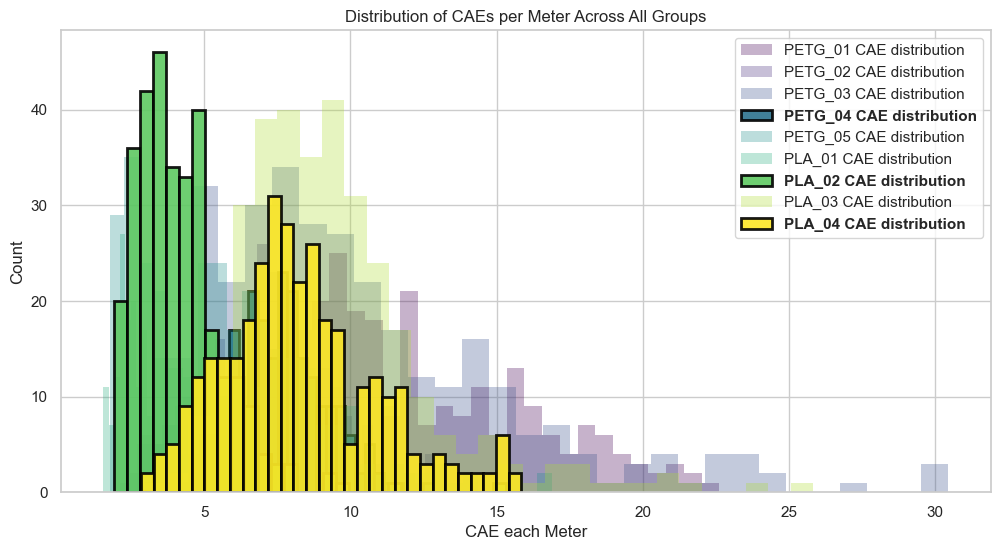

In [102]:
def calculate_cae_for_meter(df, target):
    return df['diameter_avg'].sub(target).abs().sum()

# Process each group and segment by meter
meter_results = []

for group, group_df in combined_df.groupby('group'):
    # Calculate the number of measurements per meter
    meters_per_measurement = measurement_increment / 1000
    measurements_per_meter = int(1 / meters_per_measurement)
    
    # Calculate the number of full meters in the dataset
    total_measurements = len(group_df)
    full_meters = total_measurements // measurements_per_meter
    
    # Loop through each full meter
    for i in range(full_meters):
        start_idx = i * measurements_per_meter
        end_idx = start_idx + measurements_per_meter
        meter_df = group_df.iloc[start_idx:end_idx]
        cae = calculate_cae_for_meter(meter_df, target_diameter)
        meter_results.append({'Group': group, 'Meter Number': i+1, 'CAE': cae})

# Convert results to DataFrame
meter_results_df = pd.DataFrame(meter_results)

# Specify groups of interest as a list
groups_of_interest = ['PETG_04', 'PLA_02', 'PLA_04']  # Change this list as needed or set to empty for no emphasis

# Define a function to plot histograms with unique colors and conditional emphasis
def plot_histograms(data, groups_of_interest, title):
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(data['Group'].unique())))
    for idx, group in enumerate(data['Group'].unique()):
        group_data = data[data['Group'] == group]
        if not groups_of_interest or group in groups_of_interest:
            alpha_value = 0.9
            linewidth = 2 if group in groups_of_interest else 1
            edgecolor = 'black' if group in groups_of_interest else 'none'
            weight = 'bold' if group in groups_of_interest else 'normal'
        else:
            alpha_value = 0.3
            linewidth = 1
            edgecolor = 'none'
            weight = 'normal'

        ax.hist(group_data['CAE'], bins=30, alpha=alpha_value, edgecolor=edgecolor, linewidth=linewidth, label=f'{group} CAE distribution', color=colors[idx])

    ax.set_xlabel('CAE each Meter')
    ax.set_ylabel('Count')
    ax.set_title(title)
    legend = ax.legend()
    for text in legend.get_texts():
        if groups_of_interest and text.get_text().split(" ")[0] in groups_of_interest:
            text.set_weight('bold')
    plt.show()

# Plotting with emphasis
plot_histograms(meter_results_df, groups_of_interest, 'Distribution of CAEs per Meter Across All Groups')

# Mixed Effects Model

In [ ]:
data_for_modeling = []

# Loop through each group and its sections
for group_name, segments in dataframes.items():
    if isinstance(segments, dict):  # Ensuring that the group contains nested DataFrames
        for section_name, df in segments.items():
            # Check if 'diameter_avg' is a column in the DataFrame
            if 'diameter_avg' in df.columns:
                # Create a temporary DataFrame to hold the data for this section
                temp_df = df[['diameter_avg']].dropna()  # Drop NA values in 'diameter_avg'
                temp_df['group'] = group_name  # Add a column for the group
                temp_df['section'] = section_name  # Add a column for the section
                data_for_modeling.append(temp_df)  # Append to the list

# Concatenate all the temporary DataFrames into a single DataFrame
final_data_for_model = pd.concat(data_for_modeling, ignore_index=True)

# Center the 'diameter_avg' around 1.75 mm
final_data_for_model['centered_diameter'] = final_data_for_model['diameter_avg'] - 1.75

# Fit a mixed effects model using the centered diameter as the dependent variable
model = smf.mixedlm("centered_diameter ~ group + section + group:section-1", data=final_data_for_model, groups=final_data_for_model["group"])
result = model.fit()
print(result.summary())

In [ ]:
# Extract residuals
residuals = result.resid
fitted_values = result.fittedvalues

# Linearity
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Normality of residuals
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Homoscedasticity
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Plot residuals for each group
sns.boxplot(x=final_data_for_model['group'], y=residuals)
plt.title('Residuals by Group')
plt.show()

# Plot residuals for each section
sns.boxplot(x=final_data_for_model['section'], y=residuals)
plt.title('Residuals by Section')
plt.show()

# Random Effects Normality
random_effects = result.random_effects
for group, re in random_effects.items():
    sm.qqplot(re, line='45')
    plt.title(f'Q-Q Plot of Random Effects for Group: {group}')
    plt.show()

# Statistical test for normality of residuals
stat, p_value = stats.shapiro(residuals)
print(f'Shapiro-Wilk Test for Normality of Residuals: Statistic={stat}, p-value={p_value}')

In [ ]:
# Train-test split
train_data, test_data = train_test_split(final_data_for_model, test_size=0.3, random_state=14)

# Fit the mixed effects model on the training data
train_model = smf.mixedlm("centered_diameter ~ group + section + group:section - 1", data=train_data, groups=train_data["group"])
train_result = train_model.fit()

# Predict on the testing data
test_data['predicted'] = train_result.predict(test_data) + 1.75  # Adding back the centered value

# Calculate performance metrics
mse = mean_squared_error(test_data['diameter_avg'], test_data['predicted'])
r2 = r2_score(test_data['diameter_avg'], test_data['predicted'])

print(f"Mean Squared Error on test data: {mse}")
print(f"R-squared on test data: {r2}")

# Aggregate data for plotting by group and section
aggregated_test_data = test_data.groupby(['group', 'section']).agg(
    actual_diameter=('diameter_avg', 'mean'),
    predicted_diameter=('predicted', 'mean')
).reset_index()

# Map section to color intensity
section_order = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth']
section_mapping = {section: i for i, section in enumerate(section_order)}
aggregated_test_data['color_intensity'] = aggregated_test_data['section'].map(section_mapping)

# Assign unique colors to each group dynamically
unique_groups = aggregated_test_data['group'].unique()
color_palette = sns.color_palette("husl", len(unique_groups))  # Use the husl color palette for distinct colors
group_colors = {group: color for group, color in zip(unique_groups, color_palette)}

# Plot actual vs predicted aggregated data with color intensity increasing by section
plt.figure(figsize=(14, 8))

for group_name, group_data in aggregated_test_data.groupby('group'):
    base_color = group_colors[group_name]
    palette = sns.light_palette(base_color, n_colors=len(section_order), reverse=False)
    sns.scatterplot(x='actual_diameter', y='predicted_diameter', data=group_data, label=group_name,
                    hue='color_intensity', palette=palette, legend=False)

plt.plot([aggregated_test_data['actual_diameter'].min(), aggregated_test_data['actual_diameter'].max()],
         [aggregated_test_data['actual_diameter'].min(), aggregated_test_data['actual_diameter'].max()],
         color='red', linestyle='--')

plt.title('Fitted vs Actual Diameter (Aggregated by Group and Section)')
plt.xlabel('Actual Diameter (mm)')
plt.ylabel('Predicted Diameter (mm)')
plt.grid(True)

# Create a custom legend
handles = []
for group_name, base_color in group_colors.items():
    palette = sns.light_palette(base_color, n_colors=len(section_order), reverse=False)
    for intensity, section in enumerate(section_order):
        handles.append(plt.Line2D([0], [0], marker='o', color=palette[intensity], label=f'{group_name} - {section}',
                                  markersize=8, linestyle=''))

plt.legend(handles=handles, title='Group and Section', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
final_data_for_model['predicted'] = result.fittedvalues + 1.75

# Plot conditional effects
plt.figure(figsize=(14, 8))
sns.lineplot(x='section', y='predicted', hue='group', data=final_data_for_model, marker='o')
plt.title('Conditional Effects of Groups across Sections')
plt.xlabel('Section')
plt.ylabel('Predicted Diameter (mm)')
plt.legend(title='Group')
plt.grid(True)
plt.show()

In [ ]:
# Simplify the model by removing interactions, non-significant predictors, and the intercept
simplified_model = smf.mixedlm("centered_diameter ~ group + section - 1", data=final_data_for_model, groups=final_data_for_model["group"])
simplified_result = simplified_model.fit()
print(simplified_result.summary())

# Evaluate model assumptions
residuals = final_data_for_model['centered_diameter'] - simplified_result.fittedvalues

# QQ plot of residuals
plt.figure(figsize=(8, 6))
sm.qqplot(residuals, line='s')
plt.title('QQ-Plot of Residuals')
plt.show()

# Residuals vs. Fitted Values
fitted = simplified_result.fittedvalues
plt.figure(figsize=(8, 6))
sns.scatterplot(x=fitted, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


In [ ]:
# Train-test split
train_data, test_data = train_test_split(final_data_for_model, test_size=0.3, random_state=14)

# Fit the mixed effects model on the training data
train_model = smf.mixedlm("centered_diameter ~ group + section - 1", data=train_data, groups=train_data["group"])
train_result = train_model.fit()

# Predict on the testing data
test_data['predicted'] = train_result.predict(test_data) + 1.75  # Adding back the centered value

# Calculate performance metrics
mse = mean_squared_error(test_data['diameter_avg'], test_data['predicted'])
r2 = r2_score(test_data['diameter_avg'], test_data['predicted'])

print(f"Mean Squared Error on test data: {mse}")
print(f"R-squared on test data: {r2}")

# Aggregate data for plotting by group and section
aggregated_test_data = test_data.groupby(['group', 'section']).agg(
    actual_diameter=('diameter_avg', 'mean'),
    predicted_diameter=('predicted', 'mean')
).reset_index()

# Map section to color intensity
section_order = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth']
section_mapping = {section: i for i, section in enumerate(section_order)}
aggregated_test_data['color_intensity'] = aggregated_test_data['section'].map(section_mapping)

# Assign unique colors to each group dynamically
unique_groups = aggregated_test_data['group'].unique()
color_palette = sns.color_palette("husl", len(unique_groups))  # Use the husl color palette for distinct colors
group_colors = {group: color for group, color in zip(unique_groups, color_palette)}

# Plot actual vs predicted aggregated data with color intensity increasing by section
plt.figure(figsize=(14, 8))

for group_name, group_data in aggregated_test_data.groupby('group'):
    base_color = group_colors[group_name]
    palette = sns.light_palette(base_color, n_colors=len(section_order), reverse=False)
    sns.scatterplot(x='actual_diameter', y='predicted_diameter', data=group_data, label=group_name,
                    hue='color_intensity', palette=palette, legend=False)

plt.plot([aggregated_test_data['actual_diameter'].min(), aggregated_test_data['actual_diameter'].max()],
         [aggregated_test_data['actual_diameter'].min(), aggregated_test_data['actual_diameter'].max()],
         color='red', linestyle='--')

plt.title('Fitted vs Actual Diameter (Aggregated by Group and Section)')
plt.xlabel('Actual Diameter (mm)')
plt.ylabel('Predicted Diameter (mm)')
plt.grid(True)

# Create a custom legend
handles = []
for group_name, base_color in group_colors.items():
    palette = sns.light_palette(base_color, n_colors=len(section_order), reverse=False)
    for intensity, section in enumerate(section_order):
        handles.append(plt.Line2D([0], [0], marker='o', color=palette[intensity], label=f'{group_name} - {section}',
                                  markersize=8, linestyle=''))

plt.legend(handles=handles, title='Group and Section', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
